# Attention readout and visualisation exemplary

In [1]:
# this file uses the environment called attentionviz2

In [1]:

from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit import RDConfig
import os
import sys
#plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import namedtuple
import torch
from IPython.display import SVG
from IPython.display import Image, display
import io
import numpy as np
import re

In [2]:
#to import to get attention from model
from attention_readout import gather_attention
from constants import PREDICTION_MODEL_PATH, TASK_MODEL_PATH, PARSING_REGEX, MOLNET_DIRECTORY
# PREDICTION_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models") --> pretrained models
# TASK_MODEL_PATH = Path("/data2/jgut/SoS_models/") --> finetuned models

/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
2024-08-20 10:45:22 | INFO | fairseq.tasks.text_to_speech | Pl

In [3]:
sys.path.insert(0,'/home/ifender/SOS/SMILES_or_SELFIES/atomtype_embedding_visualisation')
from atomtype_embedding_assignment import load_molnet_test_set, canonize_smiles

## Functions

In [4]:
def clean_SMILES(SMILES_tok):
    """Removing structural tokens, hydrogens, and numbers from SMILES token input

    Args:
        SMILES_tok (_list_): List of SMILES_tokens for a given SMILES

    Returns:
        _list,list_: Processed SMILES_token list and list of positions in input tokens list that were kept
        (needed to distinguish which embeddings are relevant)
    """
    SMILES_tok_prep = list()
    struc_toks = r"()=:~1234567890#"
    posToKeep = list()
    pos = 0
    for i in range(len(SMILES_tok)):
        # when it's an H in the SMILES, ignore, cannot deal
        if SMILES_tok[i] != "H" and SMILES_tok[i] != "h" and not SMILES_tok[i].isdigit() and not SMILES_tok[i].isspace():
            if any(elem in struc_toks for elem in SMILES_tok[i]) == False:
                if SMILES_tok[i] != "-":
                    SMILES_tok_prep.append(SMILES_tok[i])
                    # keep pos where you keep SMILES token
                    posToKeep.append(pos)
        pos += 1
    assert(len(posToKeep) == (len(SMILES_tok_prep))
           ), f"Length of positions-to-keep-array ({len(posToKeep)}) and length of SMILES_tok_prep ({len(SMILES_tok_prep)}) are not the same"
    print("SMILES_tok: ", SMILES_tok)
    print("posToKeep: ", posToKeep)
    print("SMILES_tok_prep: ", SMILES_tok_prep)

    return SMILES_tok_prep, posToKeep


In [5]:

def cleanAndNormalizeAttention(attention_array,posToKeep,clean_smiles):
    # filter attention tensor according to posToKeep to only keep attention for non-hydrogen atoms
    filtered_attentions = attention_array[posToKeep]
    print(len(filtered_attentions))
    assert len(clean_smiles)==len(filtered_attentions), "Assert failed"
    # condense attention depending on method chosen
    mean_values = np.mean(filtered_attentions)
    min_val = np.min(filtered_attentions)
    max_val = np.max(filtered_attentions)
    normalized_means = (filtered_attentions - min_val) / (max_val - min_val)
    print("before normalisation: ",filtered_attentions)
    print("normalized means where all values fall between 0 and 1: ",normalized_means)
    return normalized_means

In [6]:
def drawMoleculeWithAttention(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Score')
    plt.savefig("test.png")
    plt.show()
    #return svg

In [ ]:
def drawMoleculeWithAttention_change(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Change Score')
    plt.savefig("test.png")
    plt.show()
    #return svg

In [7]:
from IPython.display import SVG, display
import matplotlib.colors as mcolors

def drawMoleculeWithAttention_assubplot(orig_smiles,clean_smiles,norm_attentions, ax, colorbar_ax ):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    svg = d.GetDrawingText().replace('svg:','')
    ax.imshow(plt.imread(io.BytesIO(svg.encode('utf-8')), format='svg'))
    ax.axis('off')  # Hide axes


    img = np.array([[min_val, max_val]])
    colorbar_ax.imshow(img, cmap='viridis')
    colorbar_ax.set_visible(False)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), cax=colorbar_ax, orientation="horizontal", label='Attention Score')
    #d.FinishDrawing()
    # get the SVG string
    #svg = d.GetDrawingText()
    # fix the svg string and display it
    #display(SVG(svg.replace('svg:','')))

    # Colorbar
    #plt.figure(figsize=(4.5, 0.5))
    #img = np.array([[min_val, max_val]])
    #plt.imshow(img, cmap='viridis')
    #plt.gca().set_visible(False)
    #cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    #colba = plt.colorbar(cax=cax, orientation="horizontal")
    #colba.set_label('Attention Score')
    #plt.savefig("test.png")
    #plt.show()

In [8]:
def drawMoleculesWithAttention(orig_smiles, clean_smiles, attentions1, attentions2):
    # Setup for side-by-side comparison with space for colorbars
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.subplots_adjust(bottom=0.2, hspace=0.6)  # Adjust bottom to make space for colorbars

    for idx, attentions in enumerate([attentions1, attentions2]):
        # Generate a color map from 0-1 scaled to attentions
        min_val = attentions.min()
        max_val = attentions.max()
        print(f"Minimum and maximum attention values for molecule {idx+1}: {min_val}, {max_val}")
        norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
        scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

        mol = Chem.MolFromSmiles(orig_smiles)
        #AllChem.Compute2DCoords(mol)
        #drawer = rdMolDraw2D.MolDraw2DSVG(400, 400)
        #mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

        # Create a color map for the atoms
        atom_colors = {i: scalar_map.to_rgba(attentions[i])[:-1] for i in range(mol.GetNumAtoms())}

        # Draw the molecule with colored atoms according to attention scores
        AllChem.Compute2DCoords(mol)
        d = rdMolDraw2D.MolDraw2DSVG(400, 400)
        rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                           highlightAtomColors=atom_colors)

        d.FinishDrawing()
        # get the SVG string
        svg = d.GetDrawingText()
        # fix the svg string and display it
        display(SVG(svg.replace('svg:', '')))

        # Add colorbar below each figure
        cbar_ax = fig.add_axes([0.1 + 0.5*idx, 0.05, 0.3, 0.05])  # Position for colorbar
        img = np.array([[min_val, max_val]])
        cbar = axs[1,idx].imshow(img, cmap='viridis')
        axs[1,idx].set_visible(False)  # Hide the plot area for colorbar
        fig.colorbar(cbar, cax=cbar_ax, orientation="horizontal", label='Attention Score')
    
    plt.show()

In [9]:
def colorAtomsByAttention(smiles):
    #tokenize, only atomwise supported
    #smiles_tok = re.findall(r'Cl|.', smiles)
    smiles_tok = [elem for elem in re.split(PARSING_REGEX,smiles) if elem]
    clean_smiles,posToKeep = clean_SMILES(smiles_tok)
    # get attention from model, only BART for now
    attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

In [10]:
def gather_attention_pretrained_finetuned(smiles):
    #attention = gather_attention(smiles,
    #             smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
    #             smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
    #             selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
    #             selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    
    attention_bart_pretrained = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    attention_bart_finetuned = gather_attention(smiles,
                 smiles_atom_path=TASK_MODEL_PATH/"delaney"/"smiles_atom_isomers_bart"/"1e-05_0.2_seed_0"/"checkpoint_best.pt",
                 smiles_sentencepiece_path=TASK_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    
    return attention_bart_pretrained, attention_bart_finetuned

In [11]:
from IPython.display import SVG, display, HTML
def displayMolsSidebySide(orig_smiles, clean_smiles, attention_pretrained, attention_finetuned):
    svg_pretrained = drawMoleculeWithAttention(orig_smiles, clean_smiles, attention_pretrained)
    svg_finetuned = drawMoleculeWithAttention(orig_smiles, clean_smiles, attention_finetuned)
    
    # Correctly format HTML for side-by-side display
    html_content = f'''
    <div style="display: flex; justify-content: space-around; align-items: center;">
        <div>{svg_pretrained}</div>
        <div>{svg_finetuned}</div>
    </div>
    '''
    
    # Display the HTML content
    display(HTML(html_content))

## Main

## Checking attention on atoms before and after finetuning

In [14]:
# get SMILES of Delaney dataset
# get SMILES from task
task = "delaney"
#task = "bace_classification"
assert task in list(
    MOLNET_DIRECTORY.keys()
), f"{task} not in MOLNET tasks."

# get SMILES from task
task_SMILES, task_labels = load_molnet_test_set(task)
#print(f"SMILES: {task_SMILES} \n len task_SMILES delaney: {len(task_SMILES)}")

# make sure all task SMILES are the canonical SMILES
task_SMILES = [canonize_smiles(smiles) for smiles in task_SMILES]

# translate all task SMILES to SELFIES

print(task_SMILES)


2024-07-17 10:35:36 | INFO | deepchem.data.datasets | Loading dataset from disk.
2024-07-17 10:35:36 | INFO | deepchem.data.datasets | Loading dataset from disk.
2024-07-17 10:35:36 | INFO | deepchem.data.datasets | Loading dataset from disk.


['c1cc2ccc3cccc4ccc(c1)c2c34', 'Cc1cc(=O)[nH]c(=S)[nH]1', 'O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21', 'c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34', 'C1=Cc2cccc3cccc1c23', 'CC1CO1', 'CCN1c2ccccc2N(C)C(=S)c2cccnc21', 'CC12CCC3c4ccc(O)cc4CCC3C1CCC2=O', 'Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1', 'O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl', 'COc1c2occc2cc2ccc(=O)oc12', 'CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O', 'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C', 'c1ccc(-c2ccc(-c3ccccc3)cc2)cc1', 'CC12CC(=O)C3C(CCC4=CC(=O)CCC43C)C1CCC2=O', 'c1ccc2c(c1)sc1ccccc12', 'C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C', 'O=C(c1ccccc1)C(O)c1ccccc1', 'OCc1ccccc1OC1OC(CO)C(O)C(O)C1O', 'CC1=C2C3OC(=O)C(C)C3CCC2(C)C=CC1=O', 'O=Cc1ccc2c(c1)OCO2', 'CC1CCCCC1NC(=O)Nc1ccccc1', 'CC(=O)N(c1onc(C)c1C)S(=O)c1ccc(N)cc1', 'CC(C)CNC(=O)N1CCNC1=O', 'CNC(=O)Oc1ccccc1C1OCCO1', 'CC1=C(C(=O)Nc2ccccc2)CCCO1', 'Cn1c(=O)on(-c2ccc(Cl)c(Cl)c2)c1=O', 'c1cc2c3c(cccc3c1)CC2', 'c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12', 'Nc1cc(N2

2024-08-20 10:45:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-08-20 10:45:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-08-20 10:45:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-08-20 10:45:44 | INFO | fairseq.models.bart.model | Regis

finetuned attention: [0.01608661 0.02597775 0.01913938 0.01464855 0.01057271 0.00956755
 0.01258812 0.00954978 0.01056534 0.00985429 0.01072636 0.0163929
 0.01971853 0.04916124 0.01872322 0.02256805 0.09809586 0.0316937
 0.12695237 0.0223097  0.0085811  0.00968741 0.01070478 0.00959336
 0.00976104 0.0100021  0.00967628 0.01063442 0.00915773 0.01140067
 0.00865689 0.01313049 0.011851   0.01135243 0.01101946 0.01614356
 0.01657571 0.01237246 0.01274248 0.01301533 0.00929893 0.0140988
 0.01326872 0.00956672 0.01366147 0.01202117 0.01500641 0.01085376
 0.01328088 0.01405692 0.01618975 0.01732258 0.01528025 0.01675321
 0.01376961 0.01462008] 56
pretrained attention: [0.00885331 0.01713381 0.01624438 0.0090017  0.00940713 0.00784711
 0.00897182 0.01053291 0.01110119 0.01101337 0.01150576 0.0184292
 0.01996714 0.01818218 0.02751626 0.02848686 0.10738277 0.03048928
 0.11673234 0.02169654 0.01298503 0.01372881 0.01513366 0.00868867
 0.01359217 0.01487551 0.00872651 0.01322972 0.01211364 0.01391

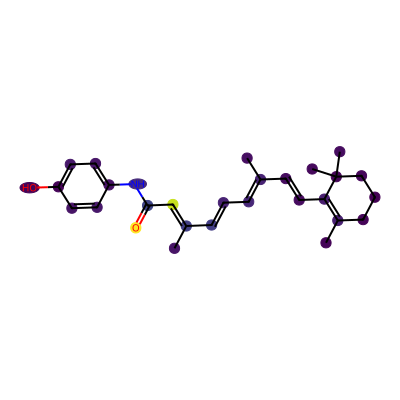

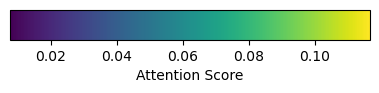

Minimum and maximum attention values: 0.00858109537512064, 0.1269523650407791


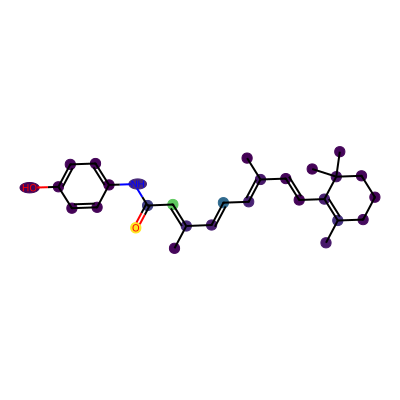

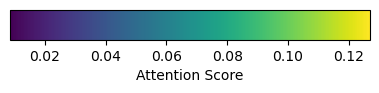

Change in attention: finetuned vs pretrained
Minimum and maximum attention values: -0.00928691029548645, 0.030979059636592865


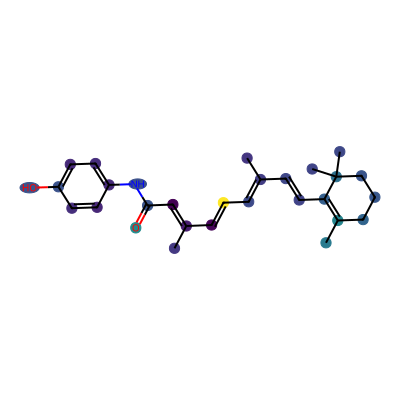

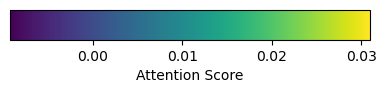

In [12]:
fenretinide = ['CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)NC2=CC=C(C=C2)O)C)C']
for smiles in fenretinide:
    attention_bart_pretrained, attention_bart_finetuned = gather_attention_pretrained_finetuned(smiles)
    attention_change = attention_bart_finetuned - attention_bart_pretrained
    print("finetuned attention:",attention_bart_finetuned, len(attention_bart_finetuned))
    print("pretrained attention:",attention_bart_pretrained, len(attention_bart_pretrained))
    print("Attention change: ",attention_change, len(attention_change))
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    clean_smiles,posToKeep = clean_SMILES(smiles)
    print("cleanSMILES:",clean_smiles)
    #norm_attention_pretrained = cleanAndNormalizeAttention(attention_bart_pretrained,posToKeep,clean_smiles)
    #norm_attention_finetuned = cleanAndNormalizeAttention(attention_bart_finetuned,posToKeep,clean_smiles)
    #print(len(norm_attention_pretrained), len(norm_attention_finetuned))
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,attention_bart_pretrained)
    drawMoleculeWithAttention(smiles,clean_smiles,attention_bart_finetuned)
    print("Change in attention: finetuned vs pretrained")
    drawMoleculeWithAttention(smiles,clean_smiles,attention_change)

2024-07-17 10:36:00 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:00 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:02 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:02 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:02 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1cc2ccc3cccc4ccc(c1)c2c34
posToKeep:  [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 18, 21, 23]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.01732512377202511, 0.11321026086807251


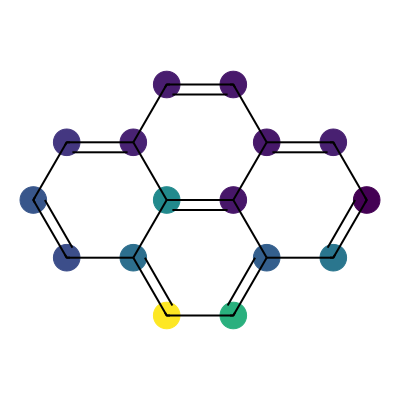

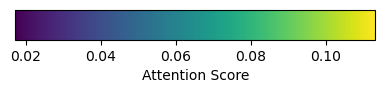

Minimum and maximum attention values: 0.018309155479073524, 0.1432066112756729


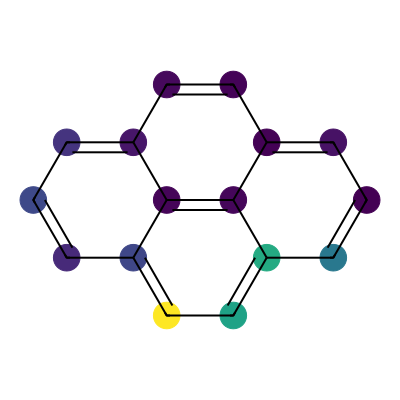

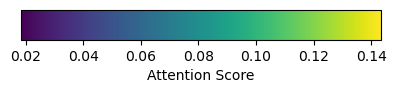

2024-07-17 10:36:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:09 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  Cc1cc(=O)[nH]c(=S)[nH]1
posToKeep:  [0, 1, 3, 4, 7, 9, 10, 12, 13, 16, 18, 19, 21]
SMILES_tok_prep:  ['C', 'c', 'c', 'c', 'O', '[', 'n', ']', 'c', 'S', '[', 'n', ']']
cleanSMILES: ['C', 'c', 'c', 'c', 'O', '[', 'n', ']', 'c', 'S', '[', 'n', ']']
Minimum and maximum attention values: 0.024740194901823997, 0.14591284096240997


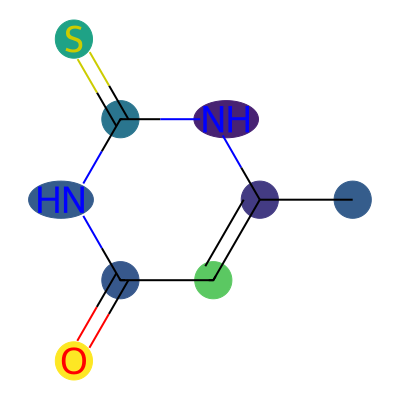

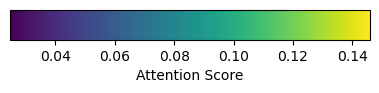

Minimum and maximum attention values: 0.019387060776352882, 0.22616249322891235


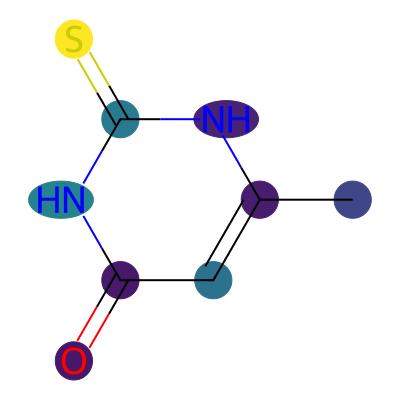

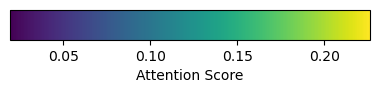

2024-07-17 10:36:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:11 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:12 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:12 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21
posToKeep:  [0, 2, 4, 5, 7, 9, 10, 11, 13, 15, 16, 20, 22, 23, 24, 26, 28, 29, 32, 34, 35, 36, 37, 38]
SMILES_tok_prep:  ['O', 'C', 'O', 'C', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['O', 'C', 'O', 'C', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.010212785564363003, 0.15200872719287872


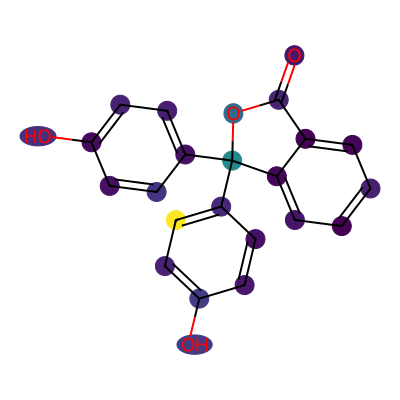

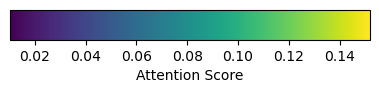

Minimum and maximum attention values: 0.00676540145650506, 0.18342159688472748


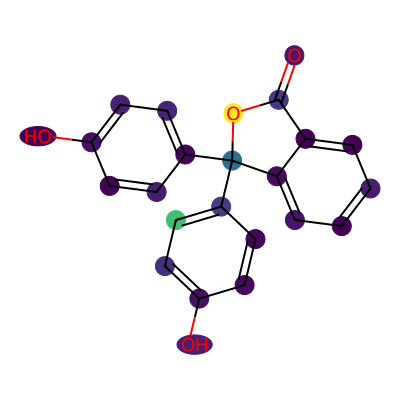

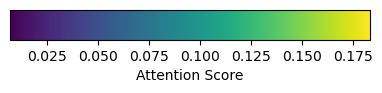

2024-07-17 10:36:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:15 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:17 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
posToKeep:  [0, 2, 3, 4, 6, 8, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 27, 29]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.011829216033220291, 0.1251126229763031


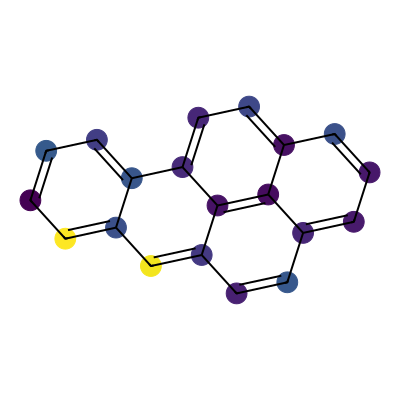

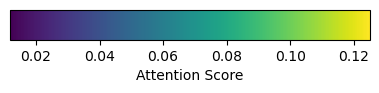

Minimum and maximum attention values: 0.010609041899442673, 0.17375804483890533


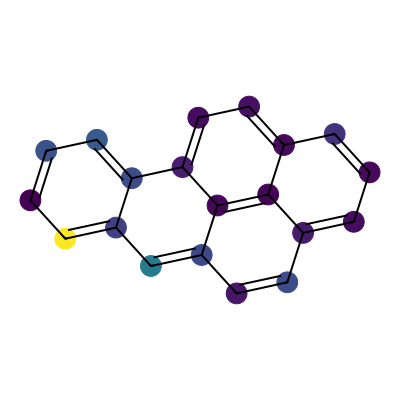

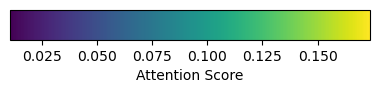

2024-07-17 10:36:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:19 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  C1=Cc2cccc3cccc1c23
posToKeep:  [0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16]
SMILES_tok_prep:  ['C', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['C', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.021569782868027687, 0.1572214663028717


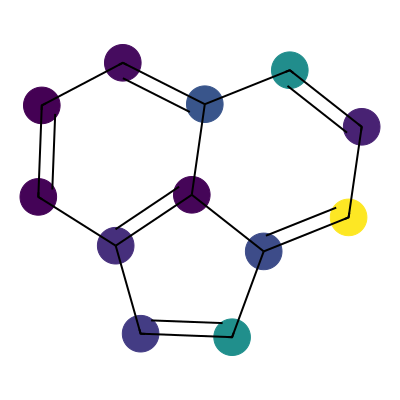

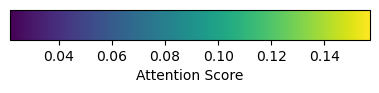

Minimum and maximum attention values: 0.01647324673831463, 0.22412501275539398


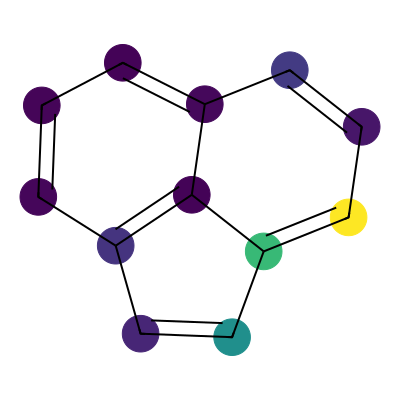

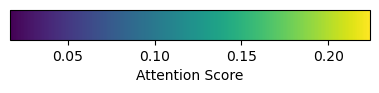

2024-07-17 10:36:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:23 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC1CO1
posToKeep:  [0, 1, 3, 4]
SMILES_tok_prep:  ['C', 'C', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'O']
Minimum and maximum attention values: 0.10607094317674637, 0.2972469627857208


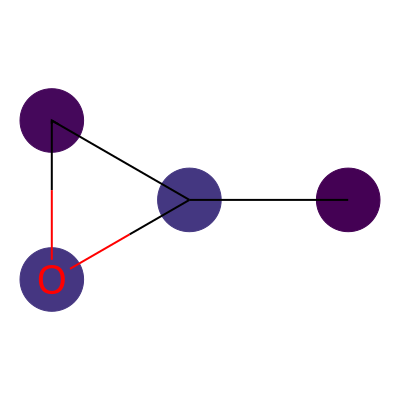

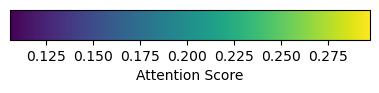

Minimum and maximum attention values: 0.12624768912792206, 0.2035914808511734


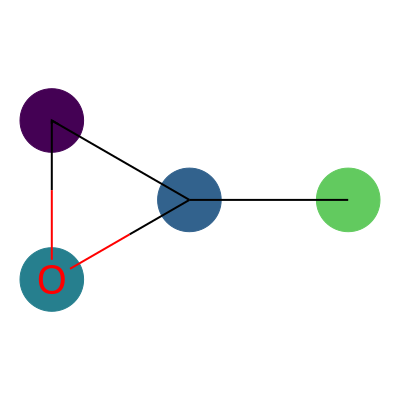

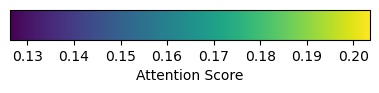

2024-07-17 10:36:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:26 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:27 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:27 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:28 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CCN1c2ccccc2N(C)C(=S)c2cccnc21
posToKeep:  [0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 19, 21, 23, 24, 25, 26, 27]
SMILES_tok_prep:  ['C', 'C', 'N', 'c', 'c', 'c', 'c', 'c', 'c', 'N', 'C', 'C', 'S', 'c', 'c', 'c', 'c', 'n', 'c']
cleanSMILES: ['C', 'C', 'N', 'c', 'c', 'c', 'c', 'c', 'c', 'N', 'C', 'C', 'S', 'c', 'c', 'c', 'c', 'n', 'c']
Minimum and maximum attention values: 0.012744688428938389, 0.10511475801467896


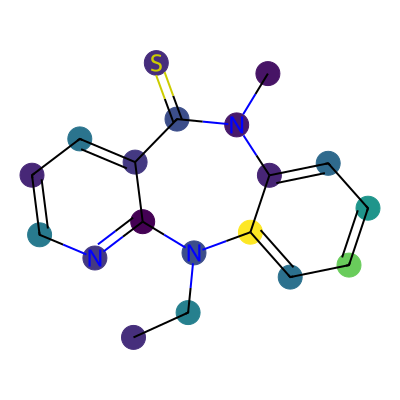

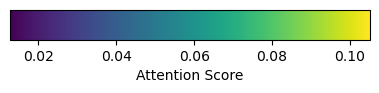

Minimum and maximum attention values: 0.011631477624177933, 0.12440303713083267


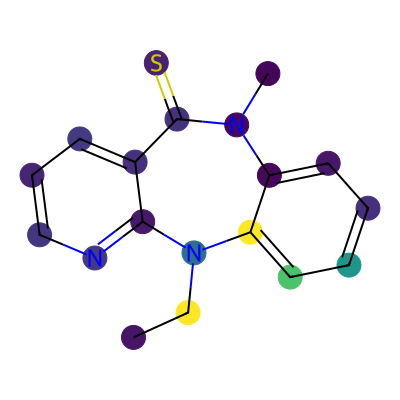

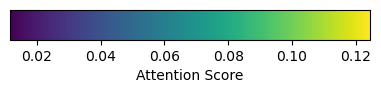

2024-07-17 10:36:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:30 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:32 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC12CCC3c4ccc(O)cc4CCC3C1CCC2=O
posToKeep:  [0, 1, 4, 5, 6, 8, 10, 11, 12, 14, 16, 17, 19, 20, 21, 23, 25, 26, 27, 30]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'C', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'C', 'C', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
Minimum and maximum attention values: 0.015413197688758373, 0.07546118646860123


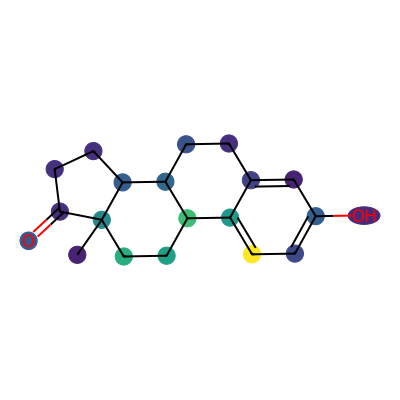

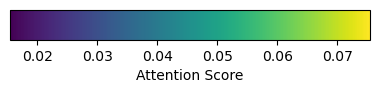

Minimum and maximum attention values: 0.007831952534615993, 0.10070148855447769


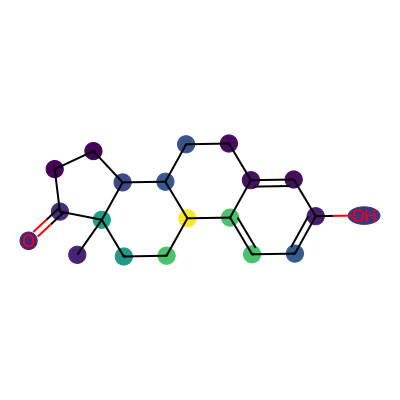

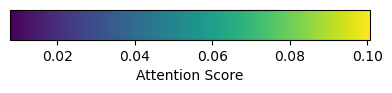

2024-07-17 10:36:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:34 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:34 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:36 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1
posToKeep:  [0, 1, 3, 4, 7, 9, 10, 11, 12, 13, 16, 19, 21, 24, 26, 27, 28, 29, 31, 33, 36, 38, 40, 43]
SMILES_tok_prep:  ['C', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'F', 'F', 'F', 'c', 'c']
cleanSMILES: ['C', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'F', 'F', 'F', 'c', 'c']
Minimum and maximum attention values: 0.007239021826535463, 0.1221967563033104


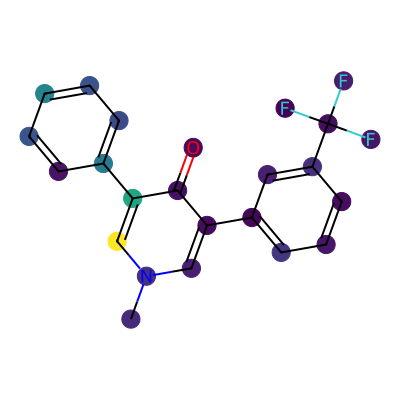

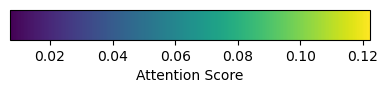

Minimum and maximum attention values: 0.007498040329664946, 0.14582906663417816


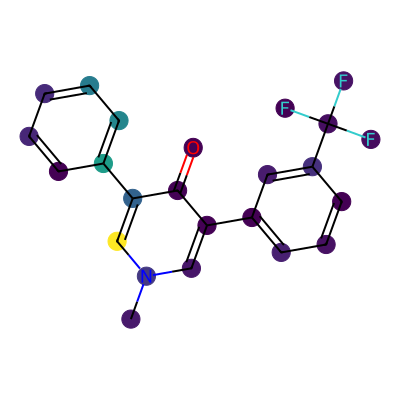

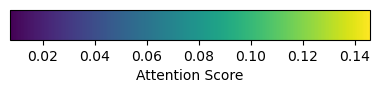

2024-07-17 10:36:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:38 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:38 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:38 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl
posToKeep:  [0, 2, 3, 4, 6, 8, 10, 11, 13, 15, 16, 18, 20, 22, 23, 26, 27, 29, 30, 32, 34, 37, 39, 40, 43, 44, 46, 47]
SMILES_tok_prep:  ['O', 'C', 'N', 'C', 'N', 'C', 'C', 'N', 'C', 'N', 'C', 'O', 'C', 'C', 'l', 'C', 'l', 'C', 'l', 'C', 'C', 'C', 'C', 'l', 'C', 'l', 'C', 'l']
cleanSMILES: ['O', 'C', 'N', 'C', 'N', 'C', 'C', 'N', 'C', 'N', 'C', 'O', 'C', 'C', 'l', 'C', 'l', 'C', 'l', 'C', 'C', 'C', 'C', 'l', 'C', 'l', 'C', 'l']
Minimum and maximum attention values: 0.0091788861900568, 0.16847746074199677


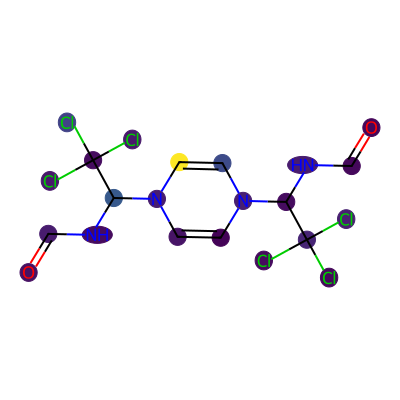

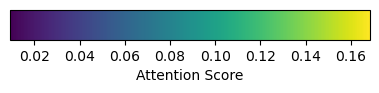

Minimum and maximum attention values: 0.007906634360551834, 0.1553136259317398


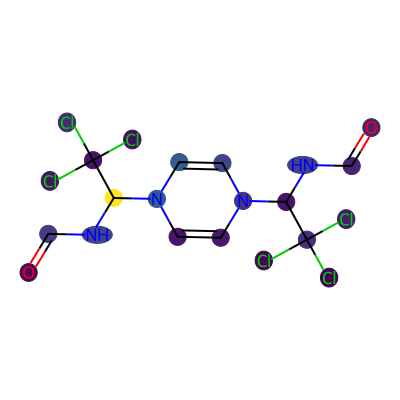

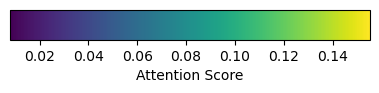

2024-07-17 10:36:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:42 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:42 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:43 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  COc1c2occc2cc2ccc(=O)oc12
posToKeep:  [0, 1, 2, 4, 6, 7, 8, 9, 11, 12, 14, 15, 16, 19, 21, 22]
SMILES_tok_prep:  ['C', 'O', 'c', 'c', 'o', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'o', 'c']
cleanSMILES: ['C', 'O', 'c', 'c', 'o', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'o', 'c']
Minimum and maximum attention values: 0.012823554687201977, 0.1728815883398056


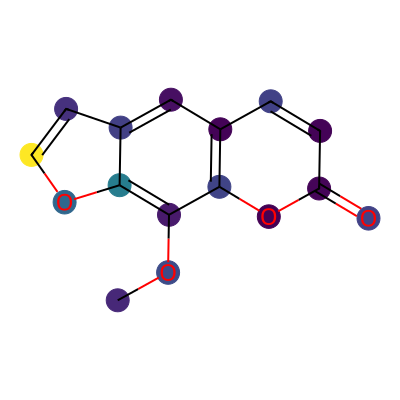

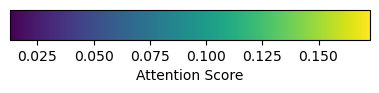

Minimum and maximum attention values: 0.010717383585870266, 0.20792990922927856


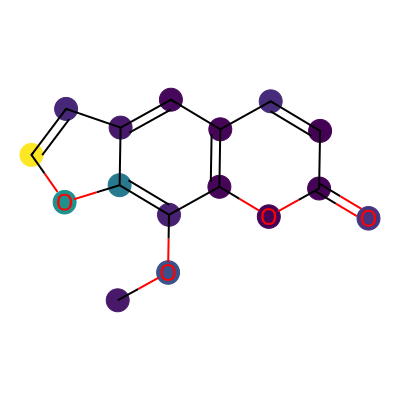

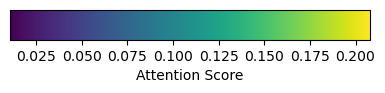

2024-07-17 10:36:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:44 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:45 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:45 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O
posToKeep:  [0, 1, 3, 5, 8, 10, 11, 13, 14, 15, 16, 17, 21, 23, 25, 27, 28, 29, 30, 31, 33, 37, 40]
SMILES_tok_prep:  ['C', 'N', 'C', 'C', 'O', 'N', 'c', 'c', 'c', 'c', 'c', 'n', 'C', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'S', 'O', 'O']
cleanSMILES: ['C', 'N', 'C', 'C', 'O', 'N', 'c', 'c', 'c', 'c', 'c', 'n', 'C', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'S', 'O', 'O']
Minimum and maximum attention values: 0.007805688306689262, 0.175672248005867


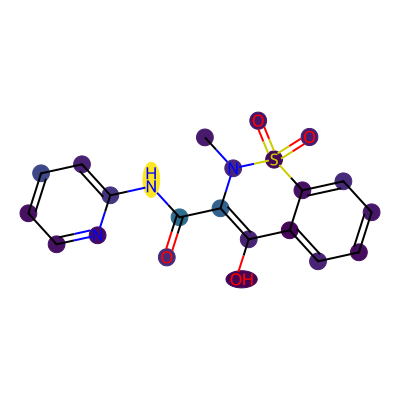

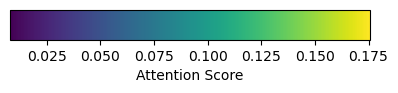

Minimum and maximum attention values: 0.006766958627849817, 0.1453680545091629


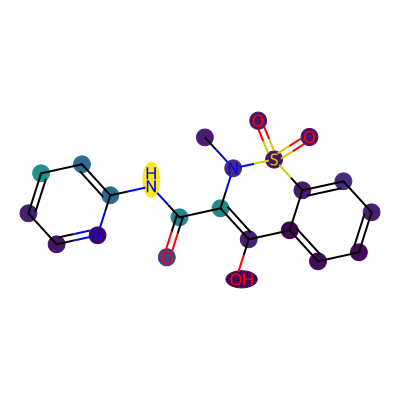

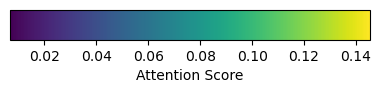

2024-07-17 10:36:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:48 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:49 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:49 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:50 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C
posToKeep:  [0, 1, 3, 4, 6, 7, 9, 12, 14, 15, 17, 18, 21, 23, 24, 27, 29, 30, 32, 34, 36, 38, 40, 42, 43, 45, 47, 48, 50]
SMILES_tok_prep:  ['C', 'c', 'c', 'c', 'n', 'c', 'c', 'O', '[', 'n', ']', 'c', 'O', 'n', 'c', 'n', 'C', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'c', 'c', 'c', 'C']
cleanSMILES: ['C', 'c', 'c', 'c', 'n', 'c', 'c', 'O', '[', 'n', ']', 'c', 'O', 'n', 'c', 'n', 'C', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'c', 'c', 'c', 'C']
Minimum and maximum attention values: 0.008625791408121586, 0.10648613423109055


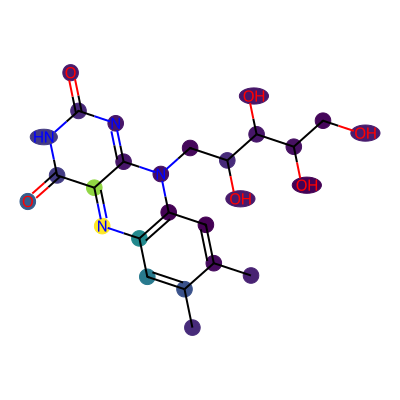

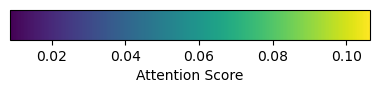

Minimum and maximum attention values: 0.006595693062990904, 0.140766441822052


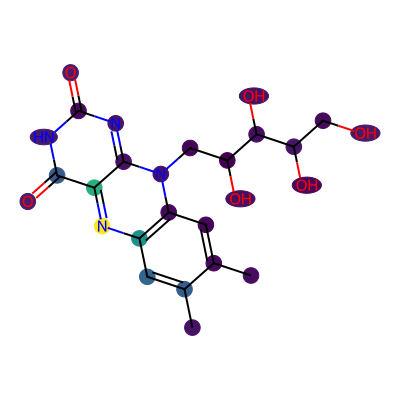

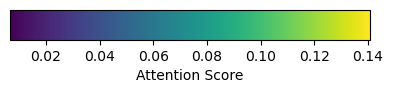

2024-07-17 10:36:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:51 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:52 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:52 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:53 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:54 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
posToKeep:  [0, 2, 3, 4, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 23, 24, 27, 28]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.012979116290807724, 0.11349978297948837


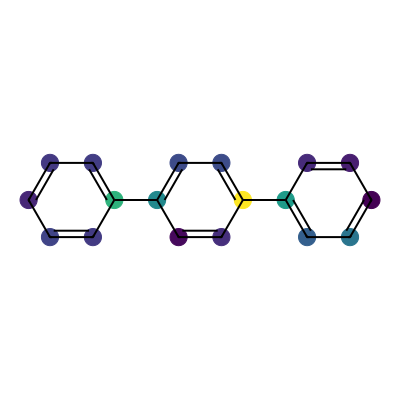

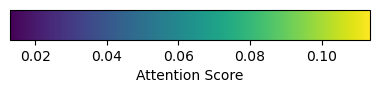

Minimum and maximum attention values: 0.012709290720522404, 0.1076761782169342


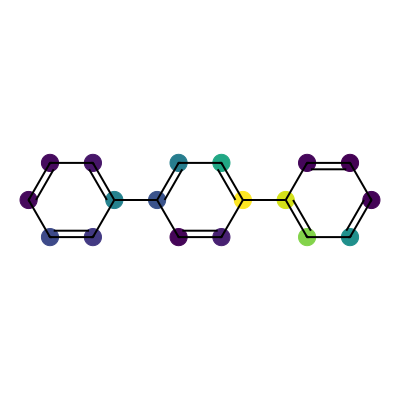

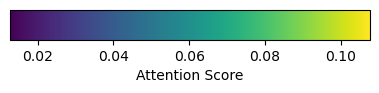

2024-07-17 10:36:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:55 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:36:56 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:36:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC12CC(=O)C3C(CCC4=CC(=O)CCC43C)C1CCC2=O
posToKeep:  [0, 1, 4, 5, 8, 10, 12, 14, 15, 16, 19, 20, 23, 25, 26, 27, 30, 32, 34, 35, 36, 39]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
Minimum and maximum attention values: 0.012665039859712124, 0.143069788813591


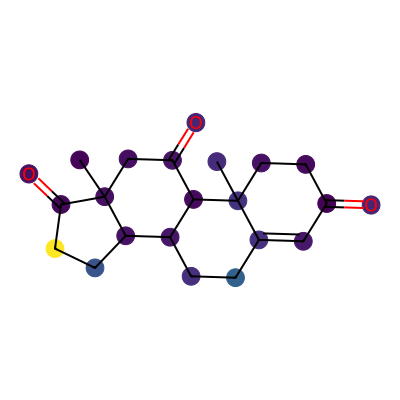

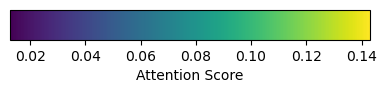

Minimum and maximum attention values: 0.01068146899342537, 0.10953075438737869


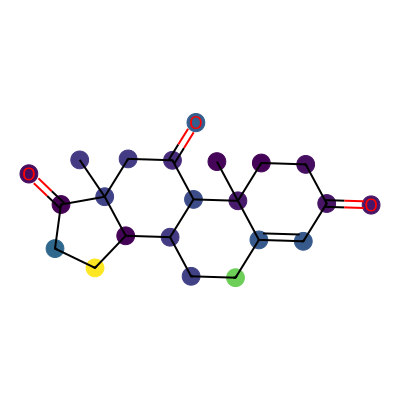

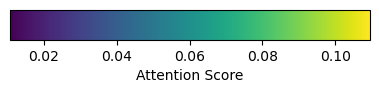

2024-07-17 10:36:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:36:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:36:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:36:59 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:00 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:00 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:01 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1ccc2c(c1)sc1ccccc12
posToKeep:  [0, 2, 3, 4, 6, 8, 11, 12, 14, 15, 16, 17, 18]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 's', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', 'c', 'c', 's', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.01846221648156643, 0.10290350764989853


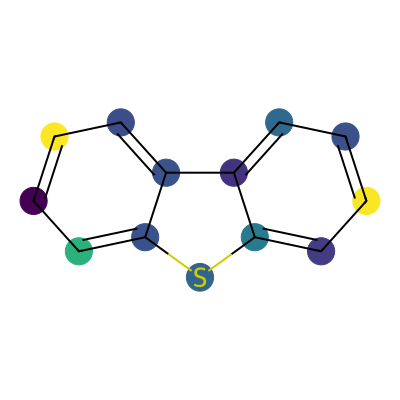

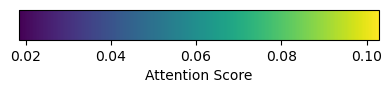

Minimum and maximum attention values: 0.01645379327237606, 0.140431210398674


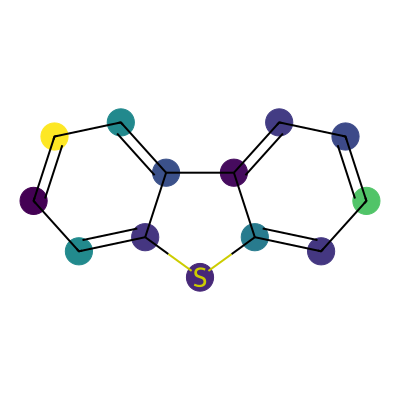

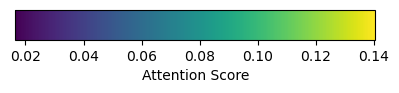

2024-07-17 10:37:02 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:02 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:03 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:03 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:05 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C
posToKeep:  [0, 2, 3, 6, 8, 9, 10, 12, 14, 15, 16, 19, 20, 22, 23, 24, 25, 27, 28, 31, 33, 35, 36, 37, 40]
SMILES_tok_prep:  ['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'c', 'o', 'n', 'c', 'c', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
cleanSMILES: ['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'c', 'o', 'n', 'c', 'c', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
Minimum and maximum attention values: 0.011413480155169964, 0.04596787691116333


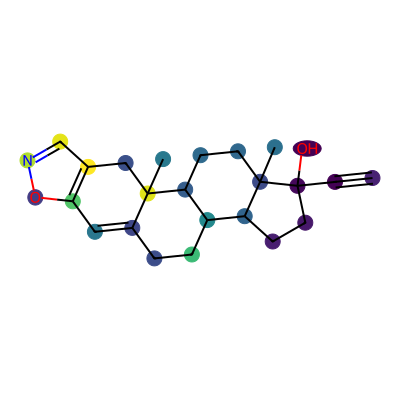

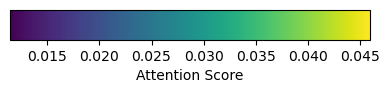

Minimum and maximum attention values: 0.009135170839726925, 0.09252694249153137


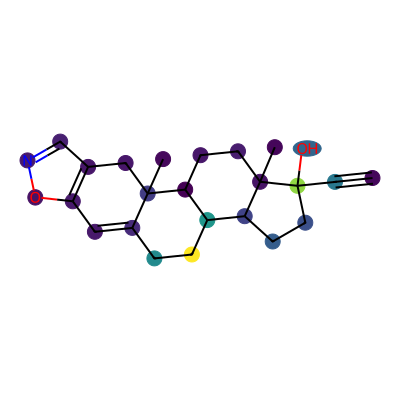

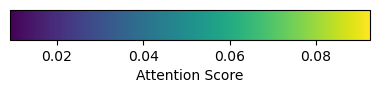

2024-07-17 10:37:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:07 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:09 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  O=C(c1ccccc1)C(O)c1ccccc1
posToKeep:  [0, 2, 4, 6, 7, 8, 9, 10, 13, 15, 17, 19, 20, 21, 22, 23]
SMILES_tok_prep:  ['O', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'O', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['O', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'O', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.016599027439951897, 0.08990152925252914


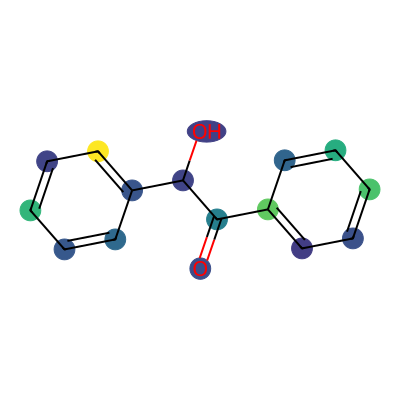

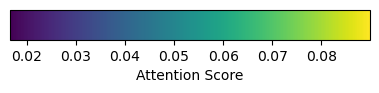

Minimum and maximum attention values: 0.01112388540059328, 0.3335994780063629


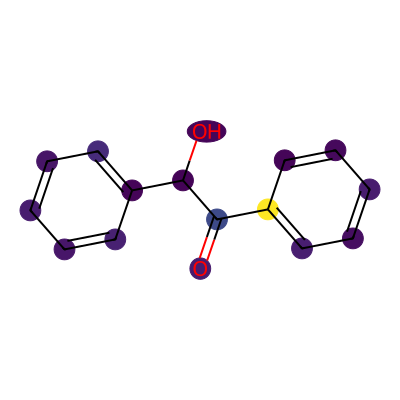

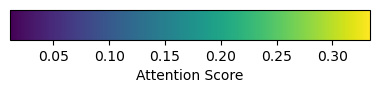

2024-07-17 10:37:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:09 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:10 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:11 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  OCc1ccccc1OC1OC(CO)C(O)C(O)C1O
posToKeep:  [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 19, 21, 23, 25, 27, 29]
SMILES_tok_prep:  ['O', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'C', 'O', 'C', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O']
cleanSMILES: ['O', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'C', 'O', 'C', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O']
Minimum and maximum attention values: 0.018474383279681206, 0.1281680017709732


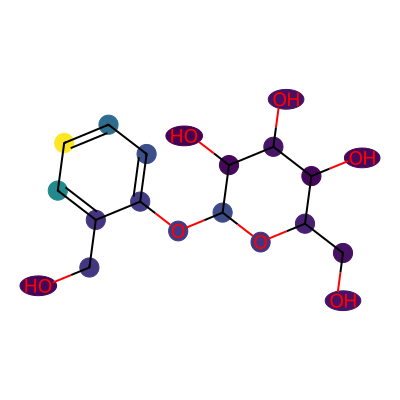

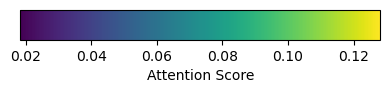

Minimum and maximum attention values: 0.01403102744370699, 0.1683064103126526


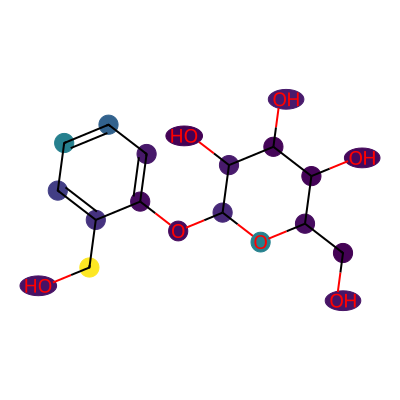

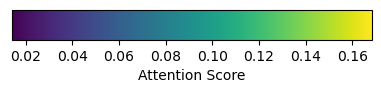

2024-07-17 10:37:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:15 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:17 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC1=C2C3OC(=O)C(C)C3CCC2(C)C=CC1=O
posToKeep:  [0, 1, 4, 6, 8, 9, 12, 14, 16, 18, 20, 21, 22, 25, 27, 29, 30, 33]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
Minimum and maximum attention values: 0.014363148249685764, 0.16880400478839874


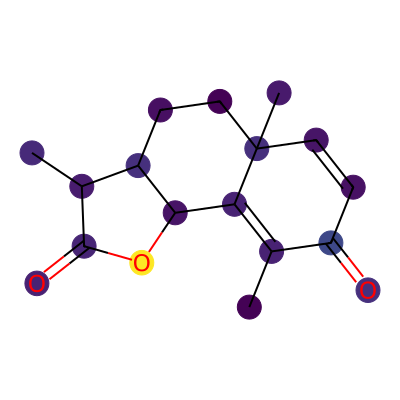

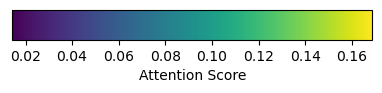

Minimum and maximum attention values: 0.012118545360863209, 0.21173769235610962


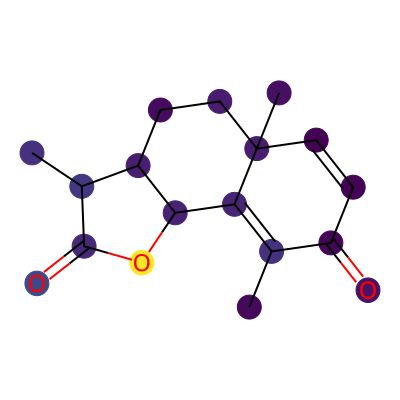

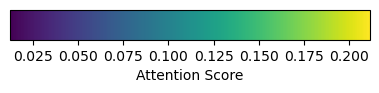

2024-07-17 10:37:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:17 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:19 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  O=Cc1ccc2c(c1)OCO2
posToKeep:  [0, 2, 3, 5, 6, 7, 9, 11, 14, 15, 16]
SMILES_tok_prep:  ['O', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'C', 'O']
cleanSMILES: ['O', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'C', 'O']
Minimum and maximum attention values: 0.025163523852825165, 0.13896287977695465


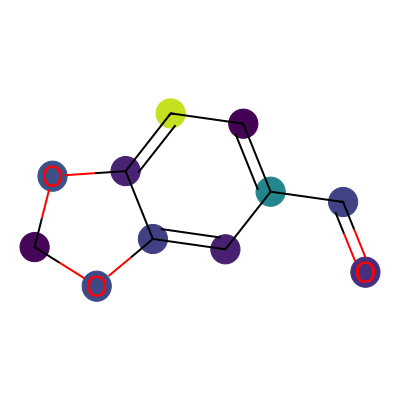

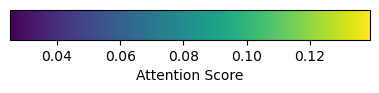

Minimum and maximum attention values: 0.012315516360104084, 0.2985830008983612


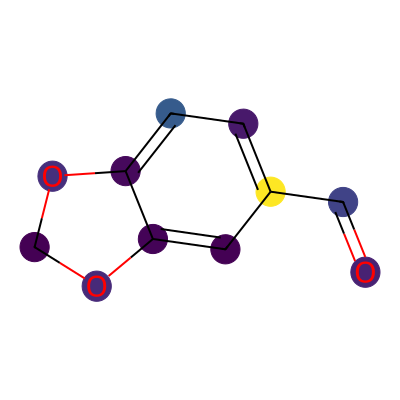

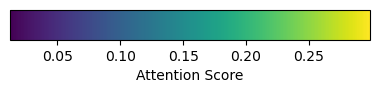

2024-07-17 10:37:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:23 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC1CCCCC1NC(=O)Nc1ccccc1
posToKeep:  [0, 1, 3, 4, 5, 6, 7, 9, 10, 13, 15, 16, 18, 19, 20, 21, 22]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'N', 'C', 'O', 'N', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'N', 'C', 'O', 'N', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.011307013221085072, 0.14562253654003143


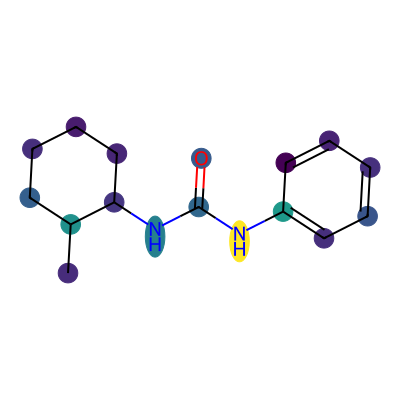

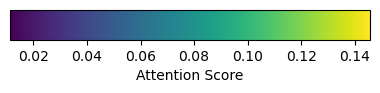

Minimum and maximum attention values: 0.011124781332910061, 0.12463157624006271


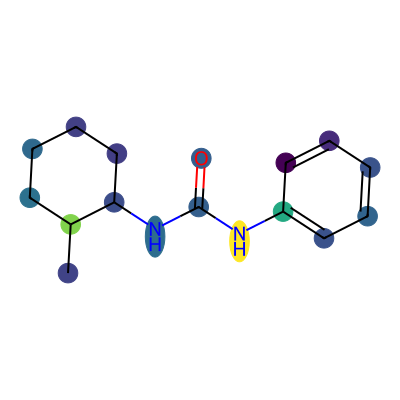

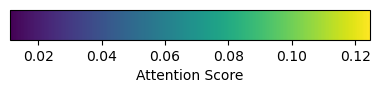

2024-07-17 10:37:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:26 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:26 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:26 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:27 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:28 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC(=O)N(c1onc(C)c1C)S(=O)c1ccc(N)cc1
posToKeep:  [0, 1, 4, 6, 8, 10, 11, 12, 14, 16, 18, 20, 23, 25, 27, 28, 29, 31, 33, 34]
SMILES_tok_prep:  ['C', 'C', 'O', 'N', 'c', 'o', 'n', 'c', 'C', 'c', 'C', 'S', 'O', 'c', 'c', 'c', 'c', 'N', 'c', 'c']
cleanSMILES: ['C', 'C', 'O', 'N', 'c', 'o', 'n', 'c', 'C', 'c', 'C', 'S', 'O', 'c', 'c', 'c', 'c', 'N', 'c', 'c']
Minimum and maximum attention values: 0.007484846282750368, 0.17647846043109894


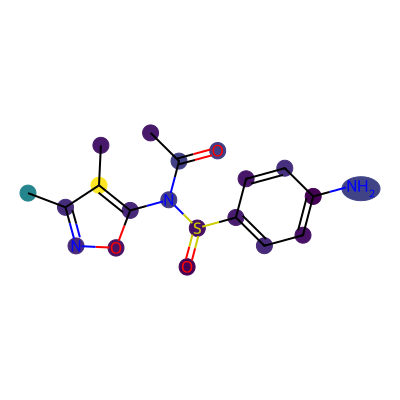

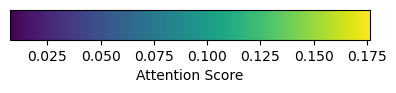

Minimum and maximum attention values: 0.005695696454495192, 0.18476907908916473


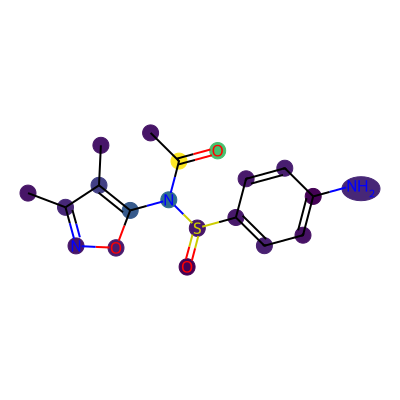

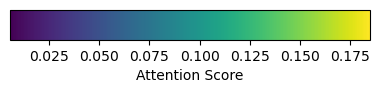

2024-07-17 10:37:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:30 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:30 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC(C)CNC(=O)N1CCNC1=O
posToKeep:  [0, 1, 3, 5, 6, 7, 10, 12, 14, 15, 16, 17, 20]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'N', 'C', 'O', 'N', 'C', 'C', 'N', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'C', 'N', 'C', 'O', 'N', 'C', 'C', 'N', 'C', 'O']
Minimum and maximum attention values: 0.01902344450354576, 0.24051547050476074


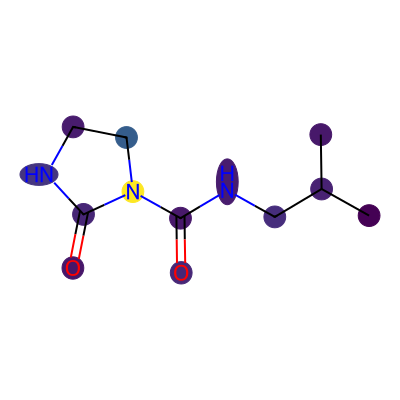

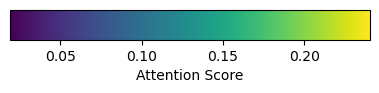

Minimum and maximum attention values: 0.01509235892444849, 0.1703123301267624


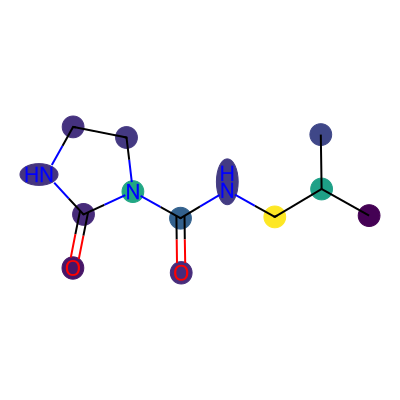

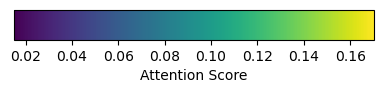

2024-07-17 10:37:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:33 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:35 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CNC(=O)Oc1ccccc1C1OCCO1
posToKeep:  [0, 1, 2, 5, 7, 8, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21]
SMILES_tok_prep:  ['C', 'N', 'C', 'O', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'O', 'C', 'C', 'O']
cleanSMILES: ['C', 'N', 'C', 'O', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'O', 'C', 'C', 'O']
Minimum and maximum attention values: 0.016846828162670135, 0.0994868278503418


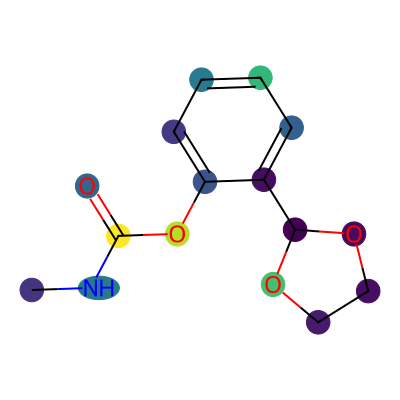

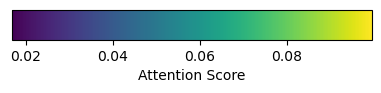

Minimum and maximum attention values: 0.007189418654888868, 0.24097184836864471


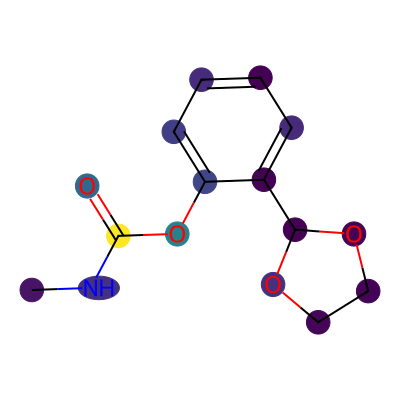

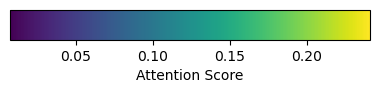

2024-07-17 10:37:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:37 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:37 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC1=C(C(=O)Nc2ccccc2)CCCO1
posToKeep:  [0, 1, 4, 6, 9, 11, 12, 14, 15, 16, 17, 18, 21, 22, 23, 24]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'N', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'C', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'C', 'O', 'N', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'C', 'C', 'O']
Minimum and maximum attention values: 0.012733031064271927, 0.14133132994174957


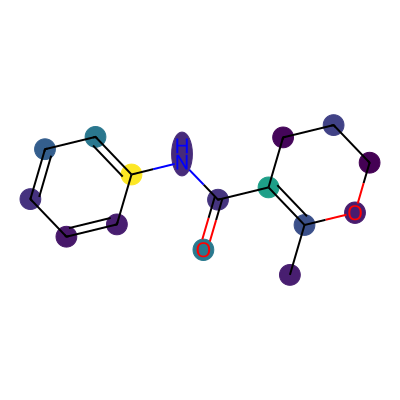

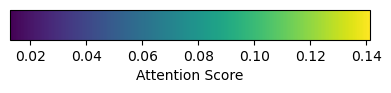

Minimum and maximum attention values: 0.007397381588816643, 0.1346890777349472


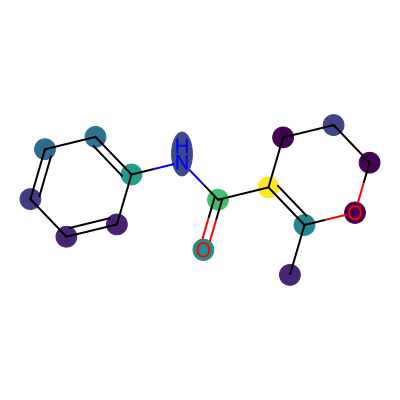

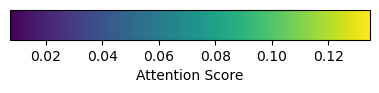

2024-07-17 10:37:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:41 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:41 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:42 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  Cn1c(=O)on(-c2ccc(Cl)c(Cl)c2)c1=O
posToKeep:  [0, 1, 3, 6, 8, 9, 12, 14, 15, 16, 18, 19, 21, 23, 24, 26, 29, 32]
SMILES_tok_prep:  ['C', 'n', 'c', 'O', 'o', 'n', 'c', 'c', 'c', 'c', 'C', 'l', 'c', 'C', 'l', 'c', 'c', 'O']
cleanSMILES: ['C', 'n', 'c', 'O', 'o', 'n', 'c', 'c', 'c', 'c', 'C', 'l', 'c', 'C', 'l', 'c', 'c', 'O']
Minimum and maximum attention values: 0.011297984980046749, 0.1302361935377121


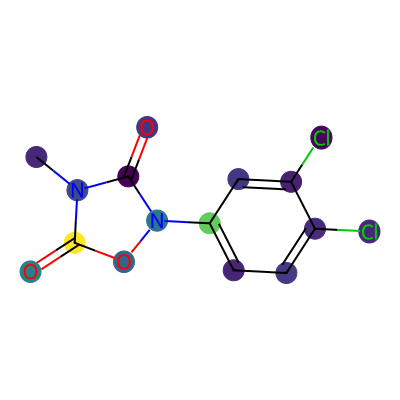

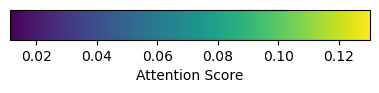

Minimum and maximum attention values: 0.010515067726373672, 0.14802013337612152


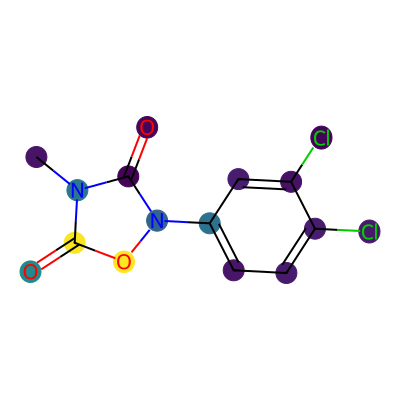

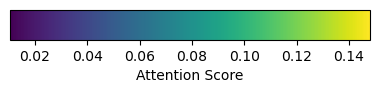

2024-07-17 10:37:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:44 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:45 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:46 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1cc2c3c(cccc3c1)CC2
posToKeep:  [0, 2, 3, 5, 7, 9, 10, 11, 12, 14, 17, 18]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'C']
cleanSMILES: ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'C']
Minimum and maximum attention values: 0.02131187729537487, 0.10202945023775101


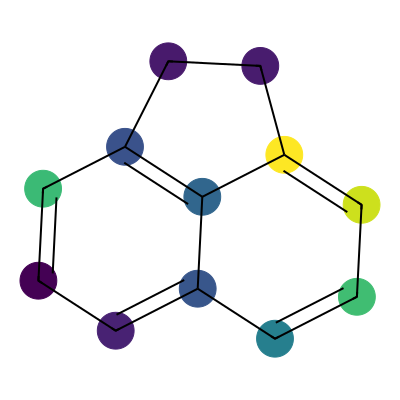

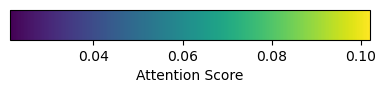

Minimum and maximum attention values: 0.023059487342834473, 0.11426498740911484


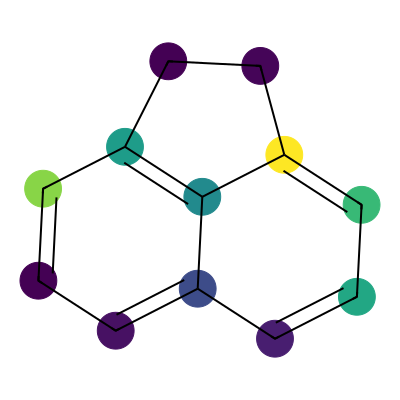

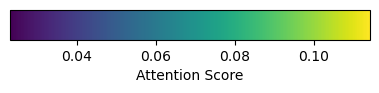

2024-07-17 10:37:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:48 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:48 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:48 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:50 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12
posToKeep:  [0, 2, 3, 4, 6, 7, 9, 11, 12, 14, 18, 20, 21, 22, 23, 25, 26, 27, 28, 31]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.009711450897157192, 0.11853090673685074


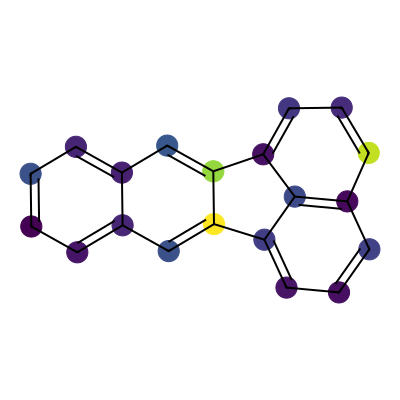

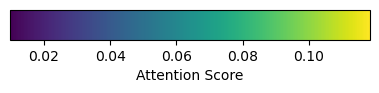

Minimum and maximum attention values: 0.008218756876885891, 0.1851080060005188


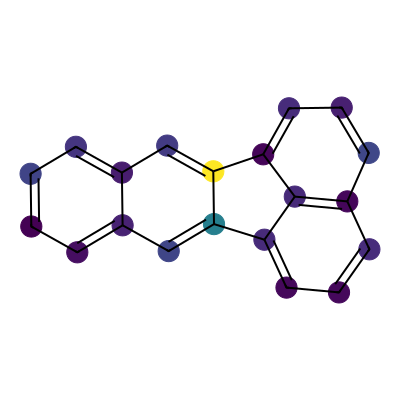

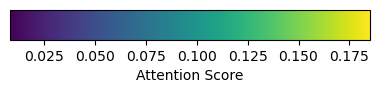

2024-07-17 10:37:50 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:50 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:52 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:52 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:53 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  Nc1cc(N2CCCCC2)nc(N)[n+]1[O-]
posToKeep:  [0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 15, 16, 18, 20, 21, 22, 23, 25, 26, 28]
SMILES_tok_prep:  ['N', 'c', 'c', 'c', 'N', 'C', 'C', 'C', 'C', 'C', 'n', 'c', 'N', '[', 'n', '+', ']', '[', 'O', ']']
cleanSMILES: ['N', 'c', 'c', 'c', 'N', 'C', 'C', 'C', 'C', 'C', 'n', 'c', 'N', '[', 'n', '+', ']', '[', 'O', ']']
Minimum and maximum attention values: 0.01909032091498375, 0.1766720414161682


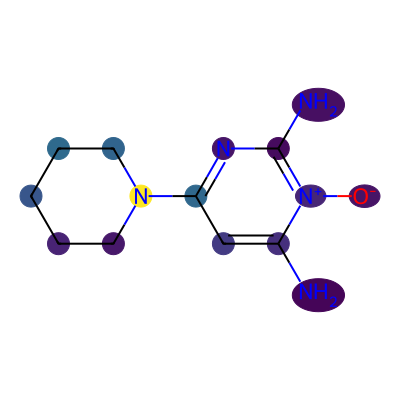

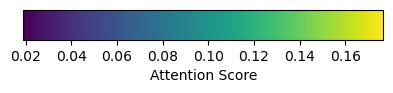

Minimum and maximum attention values: 0.01922222040593624, 0.17217296361923218


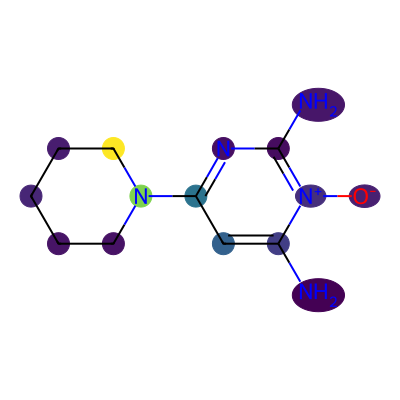

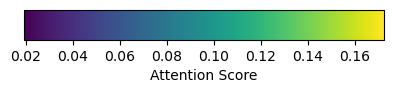

2024-07-17 10:37:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:55 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:56 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:57 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  O=c1oc2ccccc2c(O)c1C1CCCc2ccccc21
posToKeep:  [0, 2, 4, 5, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30]
SMILES_tok_prep:  ['O', 'c', 'o', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'C', 'C', 'C', 'C', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['O', 'c', 'o', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'C', 'C', 'C', 'C', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.012172897346317768, 0.10411638021469116


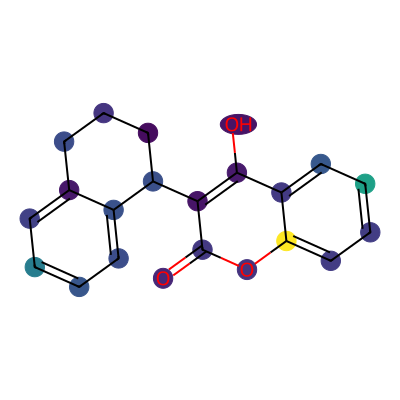

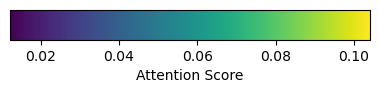

Minimum and maximum attention values: 0.009231174364686012, 0.1723797768354416


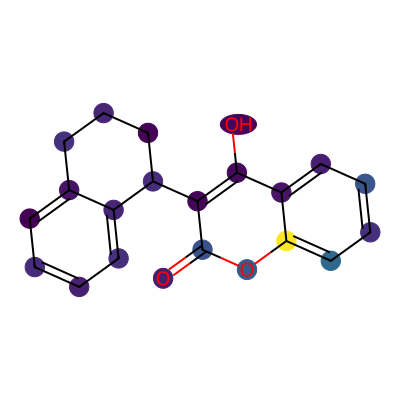

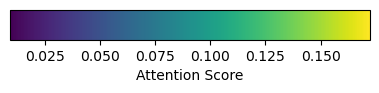

2024-07-17 10:37:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:37:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:37:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:37:59 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:37:59 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:37:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:01 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC(C)C(Nc1ccc(C(F)(F)F)cc1Cl)C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1
posToKeep:  [0, 1, 3, 5, 7, 8, 10, 11, 12, 14, 16, 19, 21, 23, 24, 26, 27, 29, 32, 34, 35, 37, 39, 41, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 58]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'N', 'c', 'c', 'c', 'c', 'C', 'F', 'F', 'F', 'c', 'c', 'C', 'l', 'C', 'O', 'O', 'C', 'C', 'N', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['C', 'C', 'C', 'C', 'N', 'c', 'c', 'c', 'c', 'C', 'F', 'F', 'F', 'c', 'c', 'C', 'l', 'C', 'O', 'O', 'C', 'C', 'N', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.003985782153904438, 0.18717382848262787


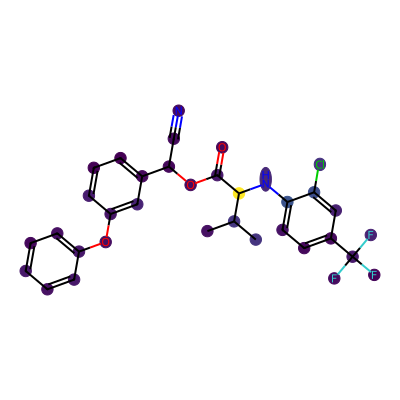

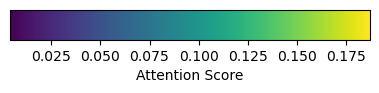

Minimum and maximum attention values: 0.0027725016698241234, 0.21130751073360443


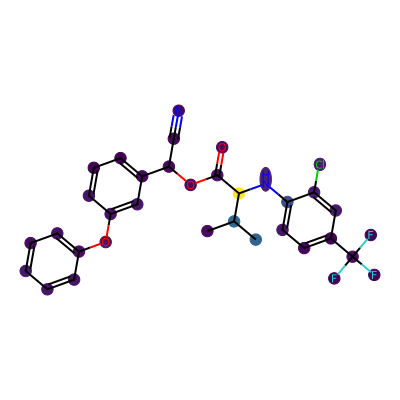

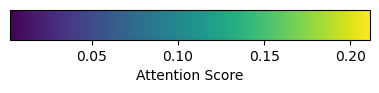

2024-07-17 10:38:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:03 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:03 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:05 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  Cc1c(F)c(F)c(COC(=O)C2C(C=C(Cl)C(F)(F)F)C2(C)C)c(F)c1F
posToKeep:  [0, 1, 3, 5, 7, 9, 11, 13, 14, 15, 18, 20, 22, 24, 26, 28, 29, 31, 33, 36, 38, 40, 43, 45, 47, 49, 51, 53]
SMILES_tok_prep:  ['C', 'c', 'c', 'F', 'c', 'F', 'c', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'l', 'C', 'F', 'F', 'F', 'C', 'C', 'C', 'c', 'F', 'c', 'F']
cleanSMILES: ['C', 'c', 'c', 'F', 'c', 'F', 'c', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'l', 'C', 'F', 'F', 'F', 'C', 'C', 'C', 'c', 'F', 'c', 'F']
Minimum and maximum attention values: 0.006045073736459017, 0.11432137340307236


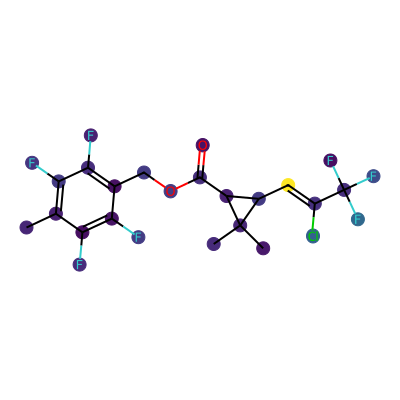

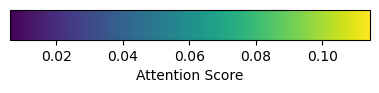

Minimum and maximum attention values: 0.006746185943484306, 0.08071532100439072


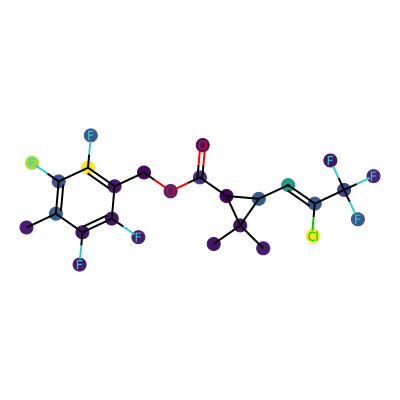

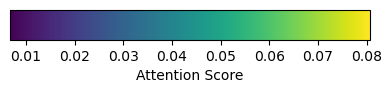

2024-07-17 10:38:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:07 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:08 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1ccc2[nH]nnc2c1
posToKeep:  [0, 2, 3, 4, 6, 7, 9, 10, 11, 12, 14]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', '[', 'n', ']', 'n', 'n', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', '[', 'n', ']', 'n', 'n', 'c', 'c']
Minimum and maximum attention values: 0.02264195866882801, 0.24107013642787933


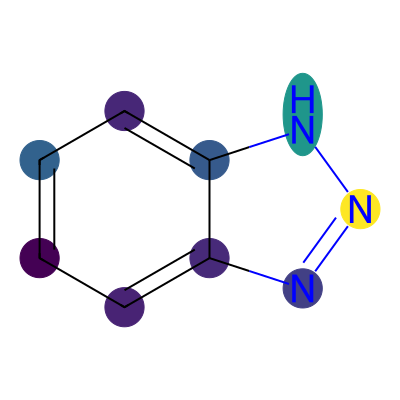

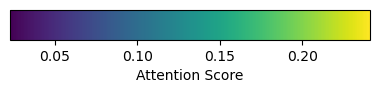

Minimum and maximum attention values: 0.019308557733893394, 0.18678371608257294


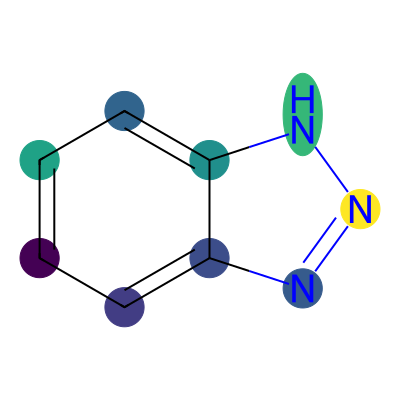

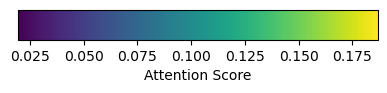

2024-07-17 10:38:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:09 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:10 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:11 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  c1ccc2ocnc2c1
posToKeep:  [0, 2, 3, 4, 6, 7, 8, 9, 11]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'o', 'c', 'n', 'c', 'c']
cleanSMILES: ['c', 'c', 'c', 'c', 'o', 'c', 'n', 'c', 'c']
Minimum and maximum attention values: 0.027397146448493004, 0.18881140649318695


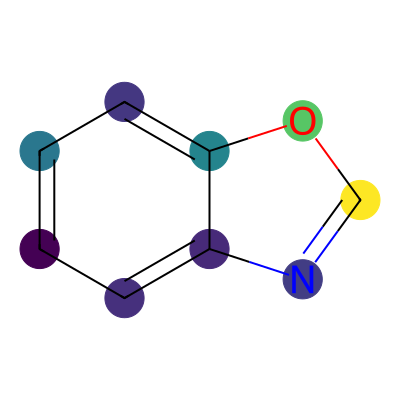

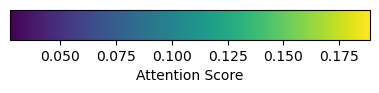

Minimum and maximum attention values: 0.0236258152872324, 0.1665026694536209


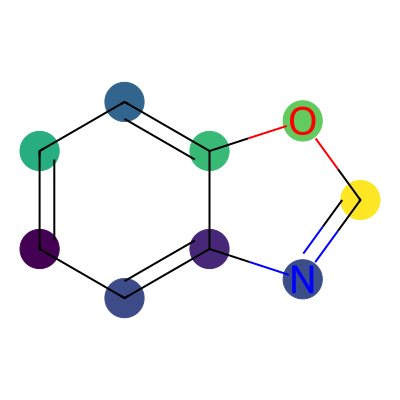

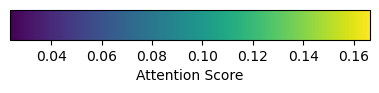

2024-07-17 10:38:12 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:12 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:14 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:14 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:16 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CCOC(=O)c1cncn1C(C)c1ccccc1
posToKeep:  [0, 1, 2, 3, 6, 8, 10, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25]
SMILES_tok_prep:  ['C', 'C', 'O', 'C', 'O', 'c', 'c', 'n', 'c', 'n', 'C', 'C', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['C', 'C', 'O', 'C', 'O', 'c', 'c', 'n', 'c', 'n', 'C', 'C', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.012371577322483063, 0.19189070165157318


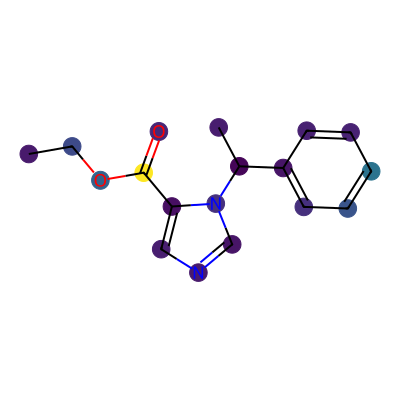

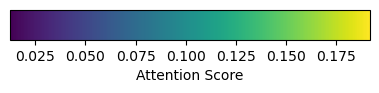

Minimum and maximum attention values: 0.008957345969974995, 0.17913484573364258


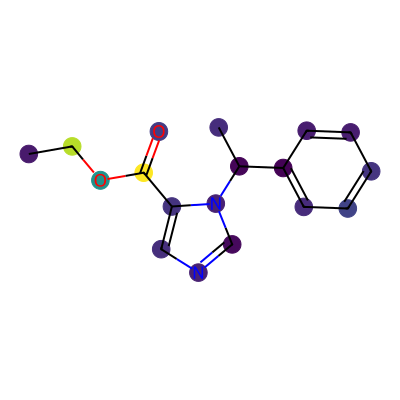

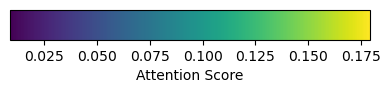

2024-07-17 10:38:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:17 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:18 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:18 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CCN1c2ccccc2C(=O)N(C)c2ccccc21
posToKeep:  [0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 15, 17, 19, 21, 23, 24, 25, 26, 27]
SMILES_tok_prep:  ['C', 'C', 'N', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'O', 'N', 'C', 'c', 'c', 'c', 'c', 'c', 'c']
cleanSMILES: ['C', 'C', 'N', 'c', 'c', 'c', 'c', 'c', 'c', 'C', 'O', 'N', 'C', 'c', 'c', 'c', 'c', 'c', 'c']
Minimum and maximum attention values: 0.012272391468286514, 0.09530369192361832


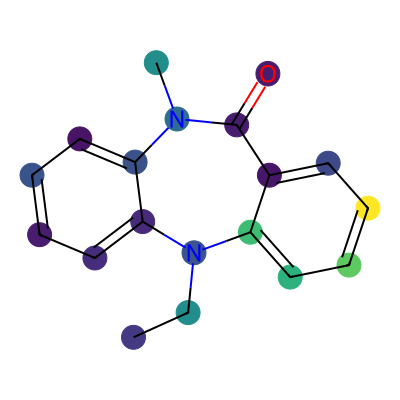

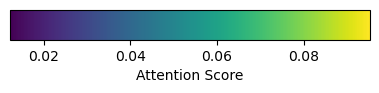

Minimum and maximum attention values: 0.010974898003041744, 0.12961970269680023


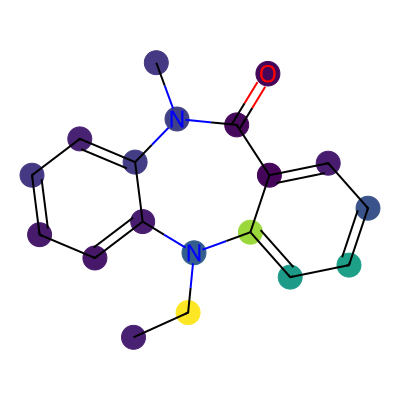

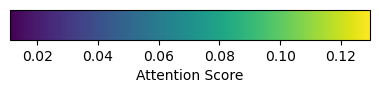

2024-07-17 10:38:20 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:20 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:22 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  O=C(OCC(O)CO)c1ccccc1Nc1ccnc2cc(Cl)ccc12
posToKeep:  [0, 2, 4, 5, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 29, 30, 32, 33, 35, 36, 37]
SMILES_tok_prep:  ['O', 'C', 'O', 'C', 'C', 'O', 'C', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'N', 'c', 'c', 'c', 'n', 'c', 'c', 'c', 'C', 'l', 'c', 'c', 'c']
cleanSMILES: ['O', 'C', 'O', 'C', 'C', 'O', 'C', 'O', 'c', 'c', 'c', 'c', 'c', 'c', 'N', 'c', 'c', 'c', 'n', 'c', 'c', 'c', 'C', 'l', 'c', 'c', 'c']
Minimum and maximum attention values: 0.00927821546792984, 0.11397664994001389


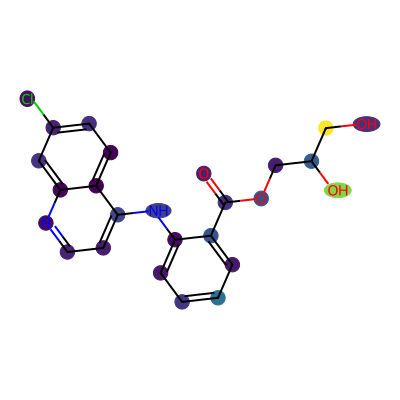

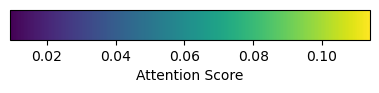

Minimum and maximum attention values: 0.0070350333116948605, 0.22929231822490692


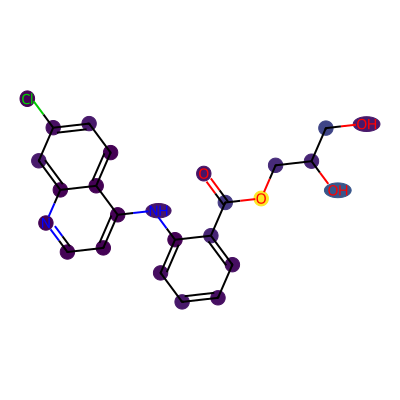

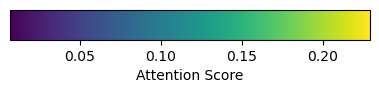

2024-07-17 10:38:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:24 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:25 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:25 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:26 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O
posToKeep:  [0, 1, 2, 4, 5, 7, 8, 10, 12, 13, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
SMILES_tok_prep:  ['O', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'O', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O']
cleanSMILES: ['O', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'O', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O']
Minimum and maximum attention values: 0.012276298366487026, 0.0760231763124466


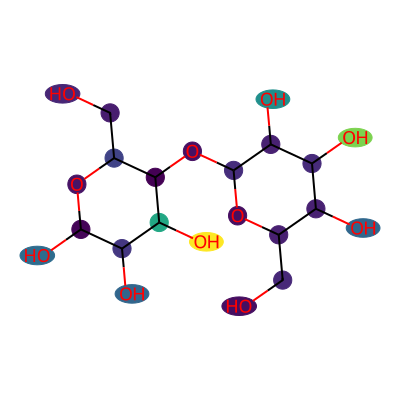

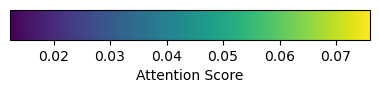

Minimum and maximum attention values: 0.011989492923021317, 0.16019093990325928


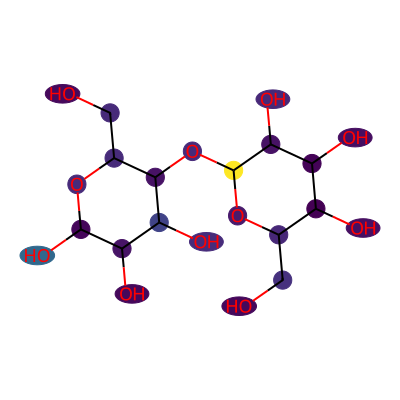

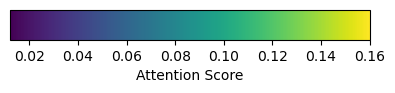

2024-07-17 10:38:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-17 10:38:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:27 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:28 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-17 10:38:29 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-17 10:38:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-17 10:38:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-17 10:38:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


SMILES_tok:  CC12CCc3c(ccc4cc(O)ccc34)C1CCC2=O
posToKeep:  [0, 1, 4, 5, 6, 8, 10, 11, 12, 14, 15, 17, 19, 20, 21, 25, 27, 28, 29, 32]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'C', 'C', 'C', 'C', 'O']
cleanSMILES: ['C', 'C', 'C', 'C', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'O', 'c', 'c', 'c', 'C', 'C', 'C', 'C', 'O']
Minimum and maximum attention values: 0.011206493712961674, 0.10374654084444046


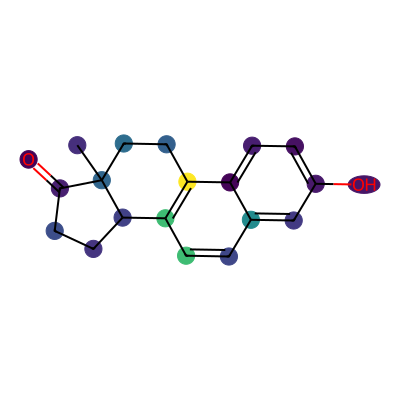

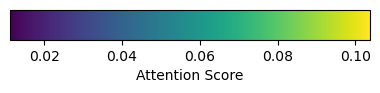

Minimum and maximum attention values: 0.008727322332561016, 0.1305469274520874


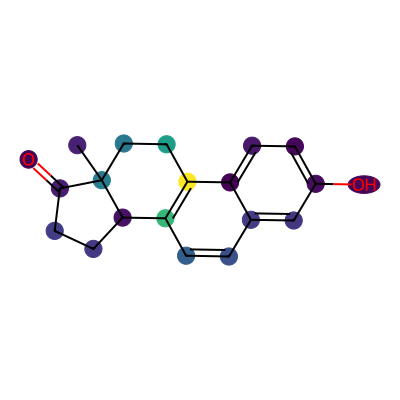

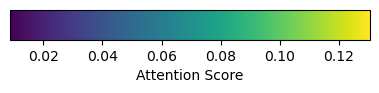

In [17]:
# just pick the first 2 mols for now
smiles_list_with_some_interest = ['Cc1cc(=O)[nH]c(=S)[nH]1','O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21', 'CC1CO1']
for smiles in task_SMILES[:40]:
    attention_bart_pretrained, attention_bart_finetuned = gather_attention_pretrained_finetuned(smiles)
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    clean_smiles,posToKeep = clean_SMILES(smiles)
    print("cleanSMILES:",clean_smiles)
    #norm_attention_pretrained = cleanAndNormalizeAttention(attention_bart_pretrained,posToKeep,clean_smiles)
    #norm_attention_finetuned = cleanAndNormalizeAttention(attention_bart_finetuned,posToKeep,clean_smiles)
    #print(len(norm_attention_pretrained), len(norm_attention_finetuned))
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,attention_bart_pretrained)
    drawMoleculeWithAttention(smiles,clean_smiles,attention_bart_finetuned)

## Visualizing Attention on specific Molecules

### Choose SMILES and get only the atoms from it

In [10]:
# get rid of structural topkens and hydrogens in SMILES
smiles="CC=CCOCC"
#only care about atomwise tokenisation
smiles_tok = [elem for elem in re.split(PARSING_REGEX,smiles) if elem]
clean_smiles,posToKeep = clean_SMILES(smiles_tok)

SMILES_tok:  ['C', 'C', '=', 'C', 'C', 'O', 'C', 'C']
posToKeep:  [0, 1, 3, 4, 5, 6, 7]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'C']


### Decide on the model to analyze and gather the attention for the previously chosen SMILES

In [23]:
attention, attention_bart_finetuned = gather_attention_pretrained_finetuned(smiles)

2024-07-12 17:51:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-07-12 17:51:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-12 17:51:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-12 17:51:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2024-07-12 17:51:47 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2024-07-12 17:51:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-07-12 17:51:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-07-12 17:51:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


### Remove attention on structural tokens and hydrogens

In [13]:
norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)

7
before normalisation:  [0.06893153 0.15361978 0.1629039  0.13042225 0.11900432 0.15390348
 0.10909128]
normalized means where all values fall between 0 and 1:  [0.         0.90120369 1.         0.6543489  0.53284583 0.9042227
 0.42735701]


### Draw Molecule

Minimum and maximum attention values: 0.0, 1.0


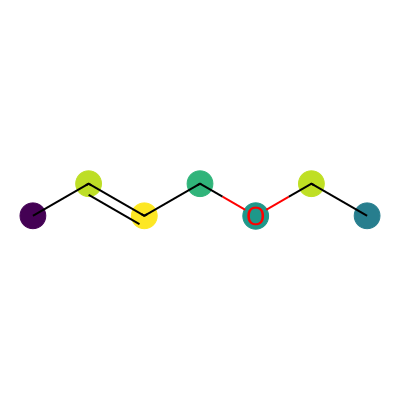

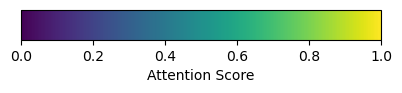

In [13]:
drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

## Chosen SMILES strings
### Looking into attention differences in symmetrical molecules:

1) c1cc2ccc3cccc4ccc(c1)c2c34 (Highly symmetrical (4 benzol rings))

2) O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl (Also very symmetrical, espc. Ns, Cls and Os in similar positions interesting to compare attention)

3) c1ccc(-c2ccc(-c3ccccc3)cc2)cc1 (three benzol rings in a chain)

4) c1ccc2c(c1)sc1ccccc12 (2 benzol rings, one five-ring )

### Looking into differences in hydrophobicity:

5) C1=CC=CC=C1 (Benzol, Solubility in water: 1.84 g/L (30 °C) (see: https://en.wikipedia.org/wiki/Benzene))

6) CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O (Aspirin, Solubility in water 3g/L (see: https://en.wikipedia.org/wiki/Aspirin))

7) C1=CC(=CC=C1C(=O)O)O (PHBA (found in: https://www.sciencedirect.com/science/article/pii/S095965262030247X#fig1), Solubility in Water 5g/L at 25 °C (https://pubchem.ncbi.nlm.nih.gov/compound/135#section=Melting-Point))

8) CCCCOC(=O)C1=CC=C(C=C1)N (Butyl 4-aminobenzoate (see: https://pubchem.ncbi.nlm.nih.gov/compound/2482#section=Melting-Point), Solubility in Water: 0.14g/L (no temperature stated))

## Symmetry within molecules

2024-06-12 18:15:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:15:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['c', '1', 'c', 'c', '2', 'c', 'c', 'c', '3', 'c', 'c', 'c', 'c', '4', 'c', 'c', 'c', '(', 'c', '1', ')', 'c', '2', 'c', '3', '4']
posToKeep:  [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 18, 21, 23]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


2024-06-12 18:15:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-06-12 18:15:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


16
before normalisation:  [0.01732512 0.0463205  0.07805961 0.05226177 0.04052735 0.04309419
 0.02633271 0.02514527 0.02384851 0.02334529 0.02311009 0.06307255
 0.03149052 0.0223051  0.02169168 0.0207397 ]
normalized means where all values fall between 0 and 1:  [0.         0.47741206 1.         0.57523576 0.38202719 0.42429057
 0.14831088 0.12875958 0.10740833 0.09912276 0.09525017 0.75323653
 0.23323482 0.08199591 0.07189586 0.0562213 ]
Minimum and maximum attention values: 0.0, 1.0


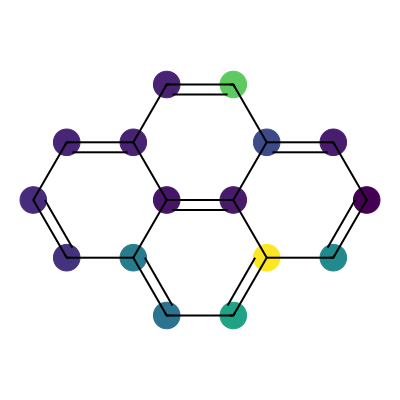

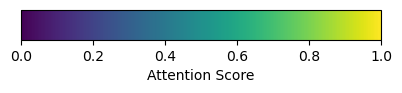

In [13]:
#1. c1cc2ccc3cccc4ccc(c1)c2c34
smiles="c1cc2ccc3cccc4ccc(c1)c2c34"
colorAtomsByAttention(smiles)

2024-06-12 18:16:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['O', '=', 'C', 'N', 'C', '(', 'N', '1', 'C', '=', 'C', 'N', '(', 'C', '(', 'N', 'C', '=', 'O', ')', 'C', '(', 'Cl', ')', '(', 'Cl', ')', 'Cl', ')', 'C', '=', 'C', '1', ')', 'C', '(', 'Cl', ')', '(', 'Cl', ')', 'Cl']
posToKeep:  [0, 2, 3, 4, 6, 8, 10, 11, 13, 15, 16, 18, 20, 22, 25, 27, 29, 31, 34, 36, 39, 41]
SMILES_tok_prep:  ['O', 'C', 'N', 'C', 'N', 'C', 'C', 'N', 'C', 'N', 'C', 'O', 'C', 'Cl', 'Cl', 'Cl', 'C', 'C', 'C', 'Cl', 'Cl', 'Cl']


2024-06-12 18:16:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


22
before normalisation:  [0.01173684 0.02129836 0.01428813 0.02295421 0.01746172 0.05337209
 0.02118052 0.01629077 0.0405372  0.01986378 0.16847746 0.02538118
 0.02308554 0.01964906 0.02146365 0.02257605 0.02203605 0.02063477
 0.01993121 0.02378906 0.02182006 0.02197297]
normalized means where all values fall between 0 and 1:  [0.         0.06100218 0.01627717 0.07156649 0.03652454 0.26563153
 0.06025039 0.02905398 0.1837454  0.05184965 1.         0.08705045
 0.07240438 0.05047974 0.06205677 0.06915385 0.06570865 0.05676854
 0.05227986 0.07689282 0.06433064 0.0653062 ]
Minimum and maximum attention values: 0.0, 1.0


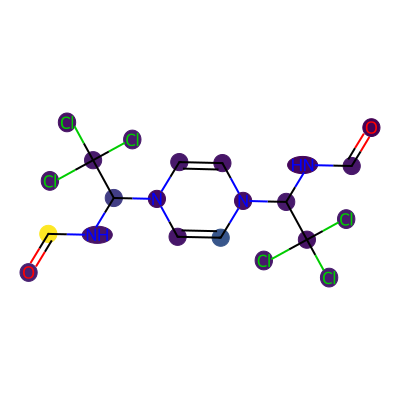

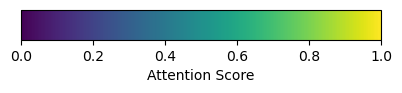

In [14]:
#2. O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl
smiles="O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl"
colorAtomsByAttention(smiles)

2024-06-12 18:16:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['c', '1', 'c', 'c', 'c', '(', '-', 'c', '2', 'c', 'c', 'c', '(', '-', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', ')', 'c', 'c', '2', ')', 'c', 'c', '1']
posToKeep:  [0, 2, 3, 4, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 23, 24, 27, 28]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


2024-06-12 18:16:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


18
before normalisation:  [0.01297912 0.04334458 0.06802297 0.11349978 0.06073381 0.03111555
 0.02986206 0.02397736 0.01561408 0.02546553 0.021467   0.01703729
 0.01650503 0.01588189 0.01616044 0.01646642 0.0142598  0.01443379]
normalized means where all values fall between 0 and 1:  [0.         0.30208176 0.54758747 1.         0.47507335 0.18042489
 0.16795491 0.10941276 0.02621317 0.12421734 0.08443919 0.04037153
 0.03507653 0.02887741 0.03164843 0.03469243 0.01274054 0.01447139]
Minimum and maximum attention values: 0.0, 1.0


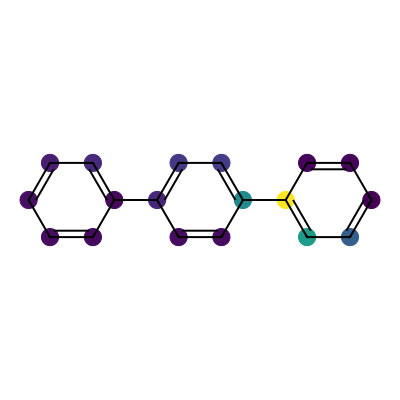

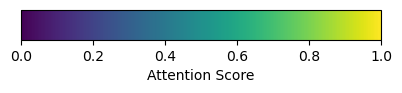

In [15]:
#3. c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
smiles="c1ccc(-c2ccc(-c3ccccc3)cc2)cc1"
colorAtomsByAttention(smiles)

2024-06-12 18:16:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['c', '1', 'c', 'c', 'c', '2', 'c', '(', 'c', '1', ')', 's', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', '2']
posToKeep:  [0, 2, 3, 4, 6, 8, 11, 12, 14, 15, 16, 17, 18]
SMILES_tok_prep:  ['c', 'c', 'c', 'c', 'c', 'c', 's', 'c', 'c', 'c', 'c', 'c', 'c']


2024-06-12 18:16:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:16 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


13
before normalisation:  [0.01846222 0.03847004 0.03993772 0.03986602 0.04589249 0.03350832
 0.04742512 0.03087555 0.02533346 0.05050772 0.0346674  0.02755889
 0.02632621]
normalized means where all values fall between 0 and 1:  [0.         0.62435672 0.67015643 0.66791897 0.85597869 0.46952288
 0.90380545 0.38736593 0.21442138 1.         0.50569279 0.28386745
 0.24540073]
Minimum and maximum attention values: 0.0, 1.0


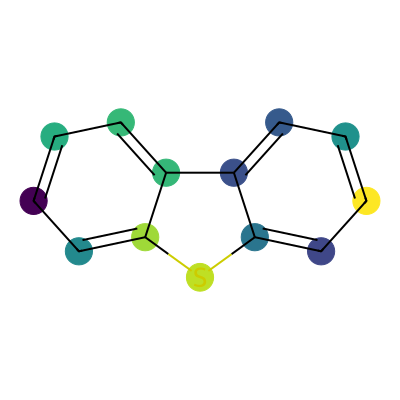

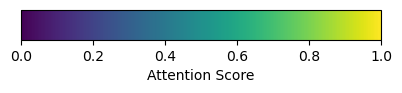

In [16]:
#4. c1ccc2c(c1)sc1ccccc12
smiles="c1ccc2c(c1)sc1ccccc12"
colorAtomsByAttention(smiles)

## Looking into different attention in hydrophobicity

2024-06-12 18:16:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1']
posToKeep:  [0, 3, 4, 6, 7, 9]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'C', 'C']


2024-06-12 18:16:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:20 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


6
before normalisation:  [0.04784407 0.10753348 0.10106575 0.19432621 0.12248549 0.06644734]
normalized means where all values fall between 0 and 1:  [0.         0.40748591 0.36333225 1.         0.50955987 0.12700026]
Minimum and maximum attention values: 0.0, 1.0


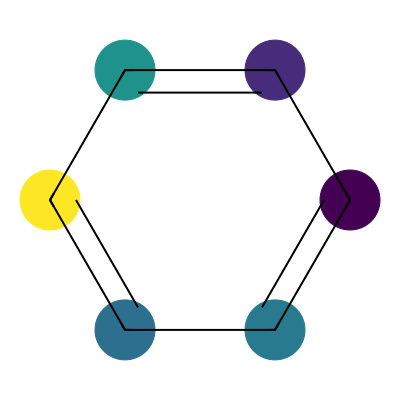

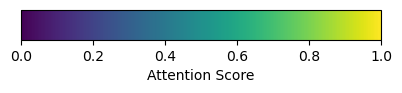

In [17]:
#5. C1=CC=CC=C1
smiles="C1=CC=CC=C1"
colorAtomsByAttention(smiles)

2024-06-12 18:16:23 | ERROR | root | failed to parse input
	SMILES: CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O
2024-06-12 18:16:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', 'C', '(', 'O', 'C', '1', '=', 'C', '(', 'C', '(', '=', 'O', ')', 'O', ')', 'C', '=', 'C', 'C', '=', 'C', '1', ')', '=', 'O', ' ', 'C', 'C', '(', '=', 'O', ')', 'O', 'C', '1', 'C', '=', 'C', 'C', '=', 'C', 'C', '=', '1', 'C', '(', 'O', ')', '=', 'O']
posToKeep:  [0, 1, 3, 4, 7, 9, 12, 14, 16, 18, 19, 21, 25, 27, 28, 31, 33, 34, 36, 38, 39, 41, 42, 45, 47, 50]
SMILES_tok_prep:  ['C', 'C', 'O', 'C', 'C', 'C', 'O', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O']


2024-06-12 18:16:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:25 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


26
before normalisation:  [0.01028921 0.01944921 0.01433563 0.01545835 0.00943689 0.01189919
 0.02670688 0.02783264 0.02156472 0.01743331 0.01227448 0.04016934
 0.04941792 0.03227781 0.03348265 0.01824608 0.01571381 0.01874536
 0.01562136 0.01472175 0.01496103 0.01355485 0.01391437 0.01423884
 0.01952189 0.0145347 ]
normalized means where all values fall between 0 and 1:  [0.02131819 0.25042671 0.12252646 0.15060779 0.         0.06158678
 0.43195454 0.46011199 0.30333965 0.20000539 0.07097331 0.76867579
 1.         0.57129389 0.60142921 0.22033407 0.15699748 0.23282223
 0.15468514 0.1321842  0.13816908 0.1029978  0.11198995 0.12010574
 0.25224449 0.1275056 ]
Minimum and maximum attention values: 0.0, 1.0


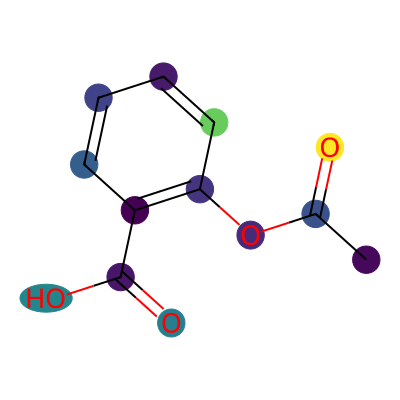

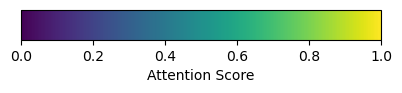

In [18]:
#6. CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O
smiles="CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O"
colorAtomsByAttention(smiles)

2024-06-12 18:16:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', '1', '=', 'C', 'C', '(', '=', 'C', 'C', '=', 'C', '1', 'C', '(', '=', 'O', ')', 'O', ')', 'O']
posToKeep:  [0, 3, 4, 7, 8, 10, 12, 15, 17, 19]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'O']


2024-06-12 18:16:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


10
before normalisation:  [0.01973738 0.0321122  0.04703133 0.10620853 0.06679316 0.0284362
 0.0369487  0.04438213 0.08234593 0.04063097]
normalized means where all values fall between 0 and 1:  [0.         0.14310926 0.31564228 1.         0.54417898 0.10059794
 0.19904117 0.28500544 0.72403974 0.24162497]
Minimum and maximum attention values: 0.0, 1.0


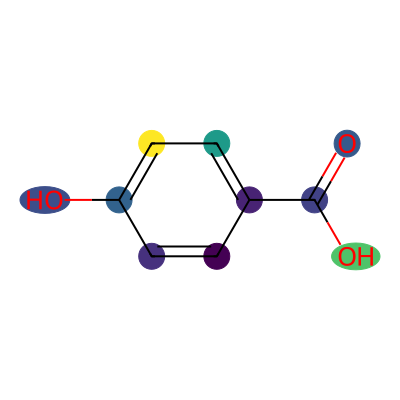

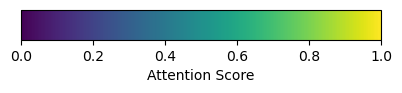

In [19]:
#7. C1=CC(=CC=C1C(=O)O)O
smiles="C1=CC(=CC=C1C(=O)O)O"
colorAtomsByAttention(smiles)

2024-06-12 18:16:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 18:16:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers


SMILES_tok:  ['C', 'C', 'C', 'C', 'O', 'C', '(', '=', 'O', ')', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'C', '=', 'C', '1', ')', 'N']
posToKeep:  [0, 1, 2, 3, 4, 5, 8, 10, 13, 14, 16, 18, 20, 23]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'N']


2024-06-12 18:16:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2024-06-12 18:16:35 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head


14
before normalisation:  [0.01743455 0.04222485 0.04936155 0.08491496 0.03505463 0.11920572
 0.03120195 0.03007838 0.02873138 0.02946542 0.0221295  0.02902189
 0.02806564 0.03785704]
normalized means where all values fall between 0 and 1:  [0.         0.24358864 0.3137136  0.66306016 0.17313428 1.
 0.13527792 0.12423783 0.11100226 0.11821484 0.04613236 0.11385681
 0.10446067 0.20067062]
Minimum and maximum attention values: 0.0, 1.0


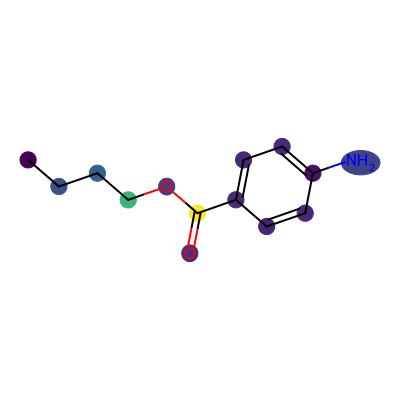

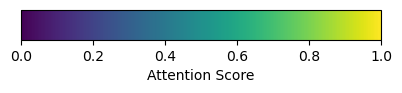

In [20]:
#8. CCCCOC(=O)C1=CC=C(C=C1)N
smiles="CCCCOC(=O)C1=CC=C(C=C1)N"
colorAtomsByAttention(smiles)